# Analysis 1000 days

## Packages

In [ ]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

/home/pjgonzalesp/miniforge3/envs/sunpy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [3]:
# mostrar un rango de datos de un TimeSeries
def show_range_ts(ts, start_idx, end_idx, height=300):
    df = ts.to_dataframe()
    subdf = df.iloc[start_idx:end_idx]
    display(HTML(f"""
    <div style="height:{height}px; overflow:auto; border:1px solid #ccc; padding:10px">
        {subdf.to_html()}
    </div>
    """))

# Uso:
#show_range_ts(goes_ts01, 0, 10)

#####################################
#     6. Calcula tiempos de FAI     #
#####################################

def calcular_fai_times(df, 
                       T_min=7, T_max=14, 
                       EM_threshold=0.005, 
                       col_T="T_cor", 
                       col_EM="EM_cor_norm"):
    """
    Calcula los tiempos en los que se cumplen los criterios del índice FAI.
    """

    # Copiar para no modificar el original
    df_fai = df.copy()

    # Condiciones del criterio FAI
    fai_condition = (
        (df_fai[col_T] >= T_min) & 
        (df_fai[col_T] <= T_max) & 
        (df_fai[col_EM] > EM_threshold)
    )

    # Selección
    df_fai_selected = df_fai[fai_condition]
    fai_times = df_fai_selected.index

    # Mostrar los resultados como en tu código original
    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")
    print(df_fai_selected[[col_T, col_EM]].head())

    return fai_times, df_fai_selected

######################
# 8. Graphs #
#######################

# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.

    Parameters:
    - df_combined: DataFrame with 'xrsa' and 'xrsb' columns and a DatetimeIndex.
    - df_fai_selected: DataFrame with temporal index for FAI events.
    - df_flare_data: DataFrame with 'event_peaktime' and 'Class' columns.
    - flare_start_time (str or pd.Timestamp): Start time of the plot interval.
    - flare_end_time (str or pd.Timestamp): End time of the plot interval.
    - ymin (float): Lower limit for y-axis (log scale).
    - ymax (float): Upper limit for y-axis (log scale).
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]


    plt.rcParams.update({
    "axes.titlesize": 16,     # título
    "axes.labelsize": 16,     # etiquetas de ejes
    "xtick.labelsize": 15,    # valores del eje X
    "ytick.labelsize": 15,    # valores del eje Y
    "legend.fontsize": 13     # texto de la leyenda
                        })
    # Create figure
    fig, ax = plt.subplots(figsize=(11, 4))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # X-axis ticks
    major_locator = mdates.MinuteLocator(byminute=range(0, 60, 10), interval=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 1)))
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4, color='gray')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()

    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

# Plot with Auto ticks for time axis
def plot_fai_and_flare_lines2(df_combined, df_fai_selected, df_flare_data, 
                              flare_start_time, flare_end_time,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare peaks.
    """
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)

    # Filter data
    df_plot = df_combined.loc[flare_start_time:flare_end_time]
    df_fai_interval = df_fai_selected.loc[flare_start_time:flare_end_time]

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 3.5))

    # Plot XRS A and B
    ax.plot(df_plot.index, df_plot['xrsa'], label='XRS A', color='blue')
    ax.plot(df_plot.index, df_plot['xrsb'], label='XRS B', color='red')

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel('Time [UTC]')
    ax.set_title('XRS A and B with FAI and Flare Peak Lines (7 < T < 14 MK and EM > 0.005)')
    ax.grid(True)

    # Red vertical lines: FAI events
    for fai_time in df_fai_interval.index:
        ax.axvline(x=fai_time, color='red', linestyle='-', linewidth=1.5, alpha=0.6)

    # Blue dashed vertical lines: flare peaks + class labels
    for _, row in df_flare_data.iterrows():
        peak_time = row['PeakTime']
        flare_class = row.get('Class', '')
        if flare_start_time <= peak_time <= flare_end_time:
            ax.axvline(x=peak_time, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            if flare_class:
                ax.annotate(flare_class,
                            xy=(peak_time, ymin * 5),
                            xytext=(peak_time + pd.Timedelta(minutes=0.2), ymin * 10),
                            fontsize=8,
                            color='blue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="blue", lw=0.5, alpha=0.6))

    # Auto ticks for time axis
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Final layout
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

# Plot T vs EM  con uno (coronal o fotosférico) o ambos modelos
def plot_T_vs_EM(df_full,
                 model="cor",   # "cor", "phot" or "both"
                 time_colors=None, 
                 title="", method_name="", integration_time="",
                 T_min=5, T_max=30, EM_min=1e46, EM_max=1e50,
                 temp_threshold=30, color_by_time=True,
                 start_time=None, end_time=None):
    """
    Plot Temperature vs Emission Measure (EM) from a DataFrame containing both models.

    Parameters
    ----------
    df_full : pandas.DataFrame
        DataFrame with columns ['T_cor','EM_cor','T_phot','EM_phot'].
    model : str, default="cor"
        Which model to plot: "cor" (coronal), "phot" (photospheric), or "both".
    time_colors : str or None
        Time limit to split colors (format 'YYYY-MM-DD HH:MM:SS').
    title : str
        Plot title.
    method_name : str
        Method label for the title.
    integration_time : str
        Integration time label for the title.
    T_min, T_max : float
        Limits for the temperature axis (MK).
    EM_min, EM_max : float
        Limits for the EM axis (cm⁻³, log scale).
    temp_threshold : float
        Maximum temperature (MK) to filter values.
    color_by_time : bool
        If True, color points by elapsed time (only applies to a single model).
    start_time, end_time : str or None
        Time interval to crop the DataFrame ('YYYY-MM-DD HH:MM:SS').

    Output
    ------
    None (shows a matplotlib plot).
    """

    # Crop DataFrame by time interval if specified
    if start_time is not None:
        start_time = pd.to_datetime(start_time)
        df_full = df_full[df_full.index >= start_time]
    if end_time is not None:
        end_time = pd.to_datetime(end_time)
        df_full = df_full[df_full.index <= end_time]

    plt.figure(figsize=(6, 5))
    t0 = df_full.index[0]

    # ---- Coronal model ----
    if model in ["cor", "both"]:
        T_cor = df_full["T_cor"].to_numpy()
        EM_cor = df_full["EM_cor"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_cor = T_cor < temp_threshold
        T_cor, EM_cor, time_cor = T_cor[mask_cor], EM_cor[mask_cor], elapsed_time[mask_cor]

        if model == "cor" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_cor <= limit_seconds
            mask_gray = time_cor > limit_seconds

            sc = plt.scatter(EM_cor[mask_colored], T_cor[mask_colored],
                             c=time_cor[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_cor[mask_gray], T_cor[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_cor, T_cor, color="red", marker="o", s=12, label="Coronal")

    # ---- Photospheric model ----
    if model in ["phot", "both"]:
        T_phot = df_full["T_phot"].to_numpy()
        EM_phot = df_full["EM_phot"].to_numpy()
        elapsed_time = (df_full.index - t0).total_seconds()

        mask_phot = T_phot < temp_threshold
        T_phot, EM_phot, time_phot = T_phot[mask_phot], EM_phot[mask_phot], elapsed_time[mask_phot]

        if model == "phot" and color_by_time and time_colors is not None:
            limit_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
            limit_seconds = (limit_dt - t0).total_seconds()
            mask_colored = time_phot <= limit_seconds
            mask_gray = time_phot > limit_seconds

            sc = plt.scatter(EM_phot[mask_colored], T_phot[mask_colored],
                             c=time_phot[mask_colored],
                             cmap="viridis", marker="+", s=30)
            plt.scatter(EM_phot[mask_gray], T_phot[mask_gray],
                        color="gray", marker=".", s=5)

            cbar = plt.colorbar(sc)
            cbar.set_label("Time since start (s)")
        else:
            plt.scatter(EM_phot, T_phot, color="blue", marker="^", s=12, label="Photospheric")

    # ---- Plot adjustments ----
    plt.xscale("log")
    plt.xlim(EM_min, EM_max)
    plt.ylim(T_min, T_max)
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(rf"{title} - {method_name}, Δt={integration_time}")
    if model == "both":
        plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


######################################
# 8. Tiempo de Anticipacion de flare #
######################################

def anticipation_fai_analysis(df_fai_selected, df_flare_data, 
                              peak_time_column="PeakTime",  
                              show_all=False, 
                              max_gap_fai=None,           # máxima anticipación permitida en minutos
                              max_gap_minutes=5,          # máxima separación entre FAIs para bloques
                              max_prev_flare_minutes=180,  # rango para calcular tiempo desde flare anterior en minutos
                              window_minutes=None          # nueva opción para ventana
                              ):
    """
    Calcula el tiempo de anticipación de cada flare a partir de FAIs previos,
    asegurando que no haya otro flare en medio y que la anticipación
    no exceda max_gap_fai si se define.

    Además, añade una columna con el tiempo en minutos desde el flare anterior
    más cercano, si este ocurre dentro de max_prev_flare_minutes.
    Incluye todas las columnas de df_fai_selected para el FAI asociado.

    Parámetros:
    - df_fai_selected: DataFrame con FAIs (índice temporal + todas las columnas)
    - df_flare_data: DataFrame con columna de tiempos de flares
    - peak_time_column: nombre de la columna de tiempo (ej. "PeakTime")
    - show_all: si False, elimina flares sin FAIs asociados
    - max_gap_minutes: separación máxima entre FAIs para formar bloques
    - max_gap_fai: máxima anticipación permitida en minutos
    - max_prev_flare_minutes: rango máximo en minutos para considerar flare anterior

    Retorna:
    - df_flare_data con columnas nuevas:
        - 'Anticipation (min)'
        - 'Previous FAI'
        - 'Time_since_prev_flare (min)'
      y todas las columnas de df_fai_selected correspondientes al FAI asociado.
    """
    df_flare_data = df_flare_data.copy()
    df_flare_data[peak_time_column] = pd.to_datetime(df_flare_data[peak_time_column])
    fai_times = pd.to_datetime(df_fai_selected.index).sort_values()
    df_flare_data = df_flare_data.sort_values(peak_time_column).reset_index(drop=True)

    anticipation_minutes = []
    used_fai = []
    time_since_prev_flare = []

    for i, peak_time in enumerate(df_flare_data[peak_time_column]):
        # 🔹 Calcular ventana válida para FAIs
        if i > 0:
            t_prev_flare = df_flare_data.loc[i-1, peak_time_column]
        else:
            t_prev_flare = pd.Timestamp.min

        valid_fais = fai_times[(fai_times > t_prev_flare) & (fai_times < peak_time)]

        # 🔹 Calcular anticipación a FAIs
        if not valid_fais.empty:
            diffs = valid_fais.to_series().diff().dt.total_seconds().div(60).fillna(0)
            group_ids = (diffs > max_gap_minutes).cumsum()
            last_group = group_ids.iloc[-1]
            group_fais = valid_fais[group_ids == last_group]

            earliest_fai = group_fais.min()
            anticipation = (peak_time - earliest_fai).total_seconds() / 60.0

            # Limitar anticipación máxima
            if max_gap_fai is not None:
                max_allowed_fai = peak_time - timedelta(minutes=max_gap_fai)
                if earliest_fai < max_allowed_fai:
                    earliest_fai = None
                    anticipation = None
        else:
            earliest_fai = None
            anticipation = None

        anticipation_minutes.append(anticipation)
        used_fai.append(earliest_fai)

        # 🔹 Calcular tiempo desde flare anterior dentro de rango
        if i > 0:
            prev_flare_time = df_flare_data.loc[i-1, peak_time_column]
            delta_min = (peak_time - prev_flare_time).total_seconds() / 60.0
            if delta_min <= max_prev_flare_minutes:
                time_since_prev_flare.append(delta_min)
            else:
                time_since_prev_flare.append(None)
        else:
            time_since_prev_flare.append(None)

    df_flare_data["Anticipation (min)"] = anticipation_minutes
    df_flare_data["Previous FAI"] = used_fai
    df_flare_data["Time_since_prev_flare (min)"] = time_since_prev_flare

    # 🔹 Adjuntar todas las columnas de df_fai_selected correspondientes al FAI usado
    if not df_flare_data.empty and not df_fai_selected.empty:
        df_flare_data = df_flare_data.merge(
            df_fai_selected, 
            how="left", 
            left_on="Previous FAI", 
            right_index=True,
            suffixes=("", "_FAI")
        )

    if not show_all:
        df_flare_data = df_flare_data[df_flare_data["Anticipation (min)"].notna()]

    return df_flare_data



# Revisa si hay un FAI en una ventana antes de cada flare
def check_fai_before_flare(fai_times, df_flare_data, flare_time_column="PeakTime", window_minutes=10):
    """
    
     Parámetros:
    - fai_times: lista/serie de timestamps de FAIs (indice (tiempo) de df_fai_selected -> tiempo que cumplen las condiciones FAI)
    - df_flare_data: DataFrame de flares
    - flare_time_column: nombre de la columna de tiempo del flare (ej. "PeakTime")
    - window_minutes: ventana para buscar flares

    Para cada flare, determina si hubo FAIs en los 'window_minutes' previos.
    Ajusta la ventana si hay un flare anterior, para que los FAIs
    no se asocien a más de un flare.

    Agrega columnas:
      - FAI_before_flare: bool (True si hubo al menos un FAI en la ventana)
      - FAI_first_time: primer FAI en la ventana
      - FAI_last_time: último FAI en la ventana
      - FAI_count: número total de FAIs en la ventana
    """
    results = df_flare_data.copy()
    results = results.sort_values(flare_time_column).reset_index(drop=True)

    results["FAI_before_flare"] = False
    results["FAI_first_time"] = pd.NaT
    results["FAI_last_time"] = pd.NaT
    results["FAI_count"] = 0

    for i, row in results.iterrows():
        flare_time = pd.to_datetime(row[flare_time_column])

        # Ventana inicial
        window_start = flare_time - pd.Timedelta(minutes=window_minutes)

        # Si hay un flare anterior y está dentro de la ventana → mover límite
        if i > 0:
            prev_flare_time = pd.to_datetime(results.loc[i-1, flare_time_column])
            if prev_flare_time > window_start:
                window_start = prev_flare_time

        window_end = flare_time

        # Buscar FAIs en la ventana ajustada
        fais_in_window = fai_times[(fai_times >= window_start) & (fai_times < window_end)]

        if len(fais_in_window) > 0:
            results.at[i, "FAI_before_flare"] = True
            results.at[i, "FAI_first_time"] = fais_in_window.min()
            results.at[i, "FAI_last_time"] = fais_in_window.max()
            results.at[i, "FAI_count"] = len(fais_in_window)

    return results


# agrupa por clases de flares en 2 grupos por clase
def assign_flare_group(flare_class):
    """
    Asigna un grupo a un flare según su clase y subnivel.
    
    Ejemplos:
    - C3.0 → C1-4
    - C7.5 → C5-9
    - X2.0 → X1-4
    - X7.0 → X5+
    """
    group_ranges = {
        "A": [(1, 4), (5, 9)],
        "B": [(1, 4), (5, 9)],
        "C": [(1, 4), (5, 9)],
        "M": [(1, 4), (5, 9)],
        "X": [(1, 4), (5, 1000)]  # 1000 actúa como "infinito"
    }

    try:
        letter = flare_class[0]  # A, B, C, M, X
        number = float(flare_class[1:])  # acepta decimales, ej: "2.7" → 2.7
    except:
        return flare_class  # si algo raro viene en el CSV

    if letter not in group_ranges:
        return flare_class

    for (low, high) in group_ranges[letter]:
        if low <= number <= high:
            if high >= 1000:  # caso abierto (ej: X5+)
                return f"{letter}{low}+"
            return f"{letter}{low}-{high}"
    
    return flare_class


#######
# csv #
#######
# Función definitiva (tamaño auto)
def plot_flare_summary_from_csv2(csv_fai_before, n_days, 
                                 window_minutes,
                                 group_subclasses=False,  # agrupar en 2 cada clase de flare True o False
                                 color_mode="palette:viridis"):  #  Elije el modo: "palette:<nombre>", "single:<color>", "by_class", "by_group" (si se activa group_subclasses=True)
                                                                 # cambiar paleta de colores palette:<nombre>:
                                                                 # "plasma", "cividis", "inferno", "magma", "tab10"
    """                     
    Lee un archivo CSV con columnas ["Class","FAI_before_flare"]
    y grafica el porcentaje de flares con FAI.
     Parámetro color_mode:
    - "palette:<nombre>" → usa paleta de Matplotlib (ej: "palette:viridis", "palette:tab10").
    - "single:<color>"   → usa un solo color (ej: "single:red", "single:#1f77b4").
    - "by_class"         → colores fijos por clase de flare (B, C, M, X)
    Parámetro group_subclasses:
    - False → usa las clases tal cual ("C9.0", "M2.5").
    - True  → agrupa en rangos:
              A/B/C/M: 1–4 y 5–9
              X: 1–4 y 5+.
    """
    """
    Lee un CSV de flares y grafica el % de FAI antes de flare por clase.
    """
   
    # -------------------------------
    # 1) Leer datos
    # -------------------------------
    df = pd.read_csv(csv_fai_before)

    # tolerancia en nombre de columna de FAI
    fai_col = None
    for cand in ["FAI_before_flare", "FAI_before", "FAI"]:
        if cand in df.columns:
            fai_col = cand
            break
    if "Class" not in df.columns or fai_col is None:
        raise ValueError("El CSV debe contener columnas 'Class' y 'FAI_before_flare' (o 'FAI_before'/'FAI').")

    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 actúa como "infinito"; se mostrará "X5+"
    }
    # -------------------------------
    # 2) Agrupación opcional por rangos
    # -------------------------------
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}-" + (f"{high}" if high<1000 else "+")
        return flare_class

    

    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(lambda x: assign_flare_group(str(x)))
    else:
        df["ClassGroup"] = df["Class"].astype(str).str[0]  # solo letra inicial

    # -------------------------------
    # 3) Cálculo de % y conteos
    # -------------------------------
    group_col = "ClassGroup"
    flare_summary = (df.groupby(group_col)[fai_col].mean() * 100).reset_index()
    flare_summary.rename(columns={fai_col: "FAI_percent"}, inplace=True)
    flare_counts = df.groupby(group_col)[fai_col].count()

    classes = flare_summary[group_col].tolist()
    values = flare_summary["FAI_percent"].tolist()
    n_bars = len(classes)

    # -------------------------------
    # 4) Colores
    # -------------------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # -------------------------------
    # 5) Tamaño dinámico + layout con eje extra para leyenda
    # -------------------------------
    # ancho crece con el número de barras para evitar amontonamiento
    chart_width = max(8, n_bars*1.2 )
    chart_height = 6

    fontsize = 8  # tamaño de letra
    item_width = 0.25 * fontsize  # relación empírica (0.25 in por punto de fuente)
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))

    # altura relativa de la "fila de leyenda": ~0.55 por fila (respecto a la parte alta que vale 6)
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 15,
    "legend.fontsize": 14
})

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=0.5) # posición leyenda debajo del gráfico

    

    # -------------------------------
    # 6) Eje principal (barras)
    # -------------------------------
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    

    # que las barras llenen el eje X
    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_xticks(range(n_bars))
    #ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_xticklabels(classes, rotation=0, ha="center")

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        if value < 100:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=14)

    # ejes/títulos
    ax.set_ylabel("FAI before flare (%)")
    ax.set_xlabel("Flare Class")
    ax.set_title(f"Percentage of flares with FAI before ({n_days} days) (window = {window_minutes} min)", 
                 pad=20) # espacio entre título y gráfica

    # -------------------------------
    # 7) Eje para la leyenda (debajo, sin solaparse jamás)
    # -------------------------------
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={flare_counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title="Number of flares per class:",
                  title_fontsize=15     # tamaño del título de la leyenda
                  )
    
    # Guardar figura en la carpeta Graphics
    output_name = f"{n_days}d_Flare_with_FAI_Window{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    

# Formato log en decimal normal
def log_decimal_format(x, pos):
    """Formato de tick: muestra 0.001, 0.01, 0.1, 1, 10, 100 sin notación científica"""
    if x >= 1:
        return f"{int(x)}"
    else:
        # Mostrar hasta 3 decimales, quitar ceros finales
        return f"{x:.3f}".rstrip("0").rstrip(".")


## prueba Leer CSV y graficar XRSA/EM y XRSB/T coloreando por clase de flare o por fecha
def plot_xrs_vs_te_from_csv2(days, 
                            csv_full ="call_df_full_100", 
                            csv_flares = "all_df_flare_data_100", 
                            time_column="PeakTime",
                            XRS="xrsa", T="T_cor", EM="EM_cor",
                            color_by=None,      # "Class" o "Date" u "Observatory"
                            palette="viridis",  
                            class_to_color=None # dict de colores fijos
                            ):
    """
    Lee datos de dos CSVs:
    - csv_full: contiene ['xrsa','xrsb','T_cor','EM_cor', ...] y un datetime index
    - csv_flares: contiene al menos la columna PeakTime
    
    Hace los gráficos:
      - XRS vs EM
      - XRS vs T
    Colores opcionales: por clase de flare o por fecha
    """

     # Leer CSV
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])

    xrs_vals, em_vals, t_vals, flare_labels = [], [], [], []

    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]
        if flare_time not in df_full.index:
            print(f"Flare en {flare_time} no encontrado en datos GOES, se salta.")
            continue

        flare_row = df_full.loc[flare_time]
        xrs_vals.append(flare_row[XRS])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare["Class"])[0])   # solo letra B,C,M,X
        elif color_by == "Date":
            flare_labels.append(flare_time.date())        # solo la fecha
        elif color_by == "Observatory":
            flare_labels.append(flare_row["observatory"]) # nombre del observatorio
        else:
            flare_labels.append("")

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Tamaños de letra
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"xrsb [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure for {days} days ({time_column})",
                      pad = 20) # espacio entre título y gráfico
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    # Limitar eje X desde 0.001 cm⁻³
    axes[0].set_xlim(0.001, None) # límite izquierdo en 0.001, derecho automático
    # Aplicar formatter personalizado al eje X
    axes[0].xaxis.set_major_formatter(FuncFormatter(log_decimal_format))

    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"xrsb [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature for {days} days ({time_column})",
                      pad= 20) #espacio entre título y gráfico
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    # Limitar eje X hasta 30 MK
    #axes[1].set_xlim(right=30)
    axes[1].set_xlim(0, 30)

    # --- Leyenda ajustada al ancho de los subplots ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left

        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        # Espacio inferior dinámico según filas
        bottom_space = 0.12 + 0.05 * (n_rows - 1)

        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.02),
                   ncol=ncol,
                   frameon=False,
                   title_fontsize=17)

        plt.subplots_adjust(bottom=bottom_space)

    # Guardar figura en la carpeta Graphics
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()



## basic xrsa vs em
def plot_xrsa_vs_em(csv_file, XRS="xrsa", EM="EM_cor"):
    """
    Lee un archivo CSV con columnas 'xrsa' y 'EM_cor'
    y grafica todos los puntos de XRS vs EM.
    """
    # Leer CSV
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    # Gráfico
    plt.figure(figsize=(7,6))
    plt.scatter(df[EM], df[XRS], alpha=0.7, c="blue")

    plt.xscale("log")
    plt.yscale("log")

    # --- Cambiar formato de ejes a 10^n ---
    plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())
    plt.gca().yaxis.set_major_formatter(LogFormatterMathtext())

    plt.xlabel(EM)
    plt.ylabel(XRS)
    plt.title(f"{XRS} vs {EM} (todos los datos)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()


############################ 
## Total Flares with FAIs ##
############################

def plot_fai_association(csv_fai_before, n, fai_column="FAI_before_flare"):
    """
    Genera una gráfica de barras mostrando cuántos flares tienen FAIs asociados.
    con porcentaje dentro de la barra y número total encima.
    
    Parámetros:
    - csv_file: ruta del archivo CSV o un DataFrame.
    - fai_column: nombre de la columna que indica si hay FAI asociado (bool).
    """
    # Si recibimos un DataFrame en lugar de un CSV
    if isinstance(csv_fai_before, pd.DataFrame):
        df = csv_fai_before
    else:
        df = pd.read_csv(csv_fai_before)
    
    # Contar cuántos flares tienen FAI y cuántos no
    counts = df[fai_column].value_counts()
    total = counts.sum()
    
    # Reordenar para que True = With FAI aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)
    
    plt.rcParams.update({
    "axes.titlesize": 14,     # título
    "axes.labelsize": 14,     # etiquetas de ejes
    "xtick.labelsize": 14,    # valores del eje X
    "ytick.labelsize": 14,    # valores del eje Y
    "legend.fontsize": 14     # texto de la leyenda
                        })

     # Crear la gráfica
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['With FAI', 'Without FAI'])
    ax.set_ylabel("Percentage of Flares (%)")
    ax.set_title(f"Flares with Associated FAIs ({n} days, Window ={window_minutes}min)",
                 pad=20) # espacio entre título y gráfico
    
    # Agregar porcentaje dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black")
    
    # Agregar número total arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', 
                    fontsize=14, color="black")
    
    # --- Leyenda con total de flares en esquina superior derecha ---
    ax.text(0.95, 0.95, f"Total Flares = {total}",
            transform=ax.transAxes,  # coordenadas relativas al eje
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura en la carpeta Graphics
    output_name = f"{n}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

###################################################
### calculo de FAIs que están asociados a Flares ##
###################################################

def associate_fai_to_flare(csv_fai_selected, csv_flares, window_minutes=30, time_ref='PeakTime'):
    """
    Asocia cada alerta FAI a un flare que ocurra dentro de una ventana hacia adelante.

    Parameters:
    - csv_fai_selected: path al CSV con alertas FAI (índice o columna Unnamed:0 = fecha/hora)
    - csv_flares: path al CSV con flares
    - window_minutes: ventana de búsqueda en minutos (hacia adelante desde la FAI)
    - time_ref: 'PeakTime' o 'StartTime', qué hora del flare usar para medir distancia

    Returns:
    - df_fai: DataFrame de FAIs con columnas adicionales sobre el flare asociado
    """
    # Leer los CSV
    df_fai = pd.read_csv(csv_fai_selected)
    df_flares = pd.read_csv(csv_flares)

    # La columna de tiempo está en "Unnamed: 0"
    df_fai['Time_FAI'] = pd.to_datetime(df_fai['Unnamed: 0'])

    # Asegurar formato datetime en flares
    df_flares['StartTime'] = pd.to_datetime(df_flares['StartTime'])
    df_flares['EndTime'] = pd.to_datetime(df_flares['EndTime'])
    df_flares['PeakTime'] = pd.to_datetime(df_flares['PeakTime'])

    # Inicializar columnas
    df_fai['Associated_Flare'] = False
    df_fai['Flare_StartTime'] = pd.NaT
    df_fai['Flare_EndTime'] = pd.NaT
    df_fai['Flare_PeakTime'] = pd.NaT
    df_fai['Flare_Class'] = None
    df_fai['Time_to_flare'] = None

    window = pd.Timedelta(minutes=window_minutes)

    for idx, row in df_fai.iterrows():
        fai_time = row['Time_FAI']

        # Flares dentro de la ventana hacia adelante
        mask = (df_flares[time_ref] >= fai_time) & (df_flares[time_ref] <= fai_time + window)
        candidate_flares = df_flares[mask].sort_values(time_ref)

        if not candidate_flares.empty:
            flare = candidate_flares.iloc[0]  # Tomamos el primero
            df_fai.at[idx, 'Associated_Flare'] = True
            df_fai.at[idx, 'Flare_StartTime'] = flare['StartTime']
            df_fai.at[idx, 'Flare_EndTime'] = flare['EndTime']
            df_fai.at[idx, 'Flare_PeakTime'] = flare['PeakTime']
            df_fai.at[idx, 'Flare_Class'] = flare['Class']
            df_fai.at[idx, 'Time_to_flare'] = (flare[time_ref] - fai_time).total_seconds() / 60  # minutos

    return df_fai

####################################################
### FAI Alerts Associated with Flares - 2 columnas##
####################################################

def plot_fai_association_summary(csv_fai_assoc, window, column="Associated_Flare"):
    """
    Reads a CSV with FAIs and generates a bar plot showing the percentage of FAIs
    that are associated with flares (True) and not associated (False).

    Parameters
    ----------
    csv_fai_assoc : str
        Path to the CSV file containing FAIs (must include column 'Associated_Flare').
    window_minutes : int
        Time window (minutes) used to define association (for title context).
    column : str, default="Associated_Flare"
        Column name with True/False values.
    """
    # Read the CSV
    df_fai = pd.read_csv(csv_fai_assoc)

    # Count True (associated) vs False (not associated)
    counts = df_fai[column].value_counts()
    total = counts.sum()

    # Reorder so True = Associated appears first
    counts = counts.reindex([True, False])

    # Percentages
    percentages = (counts / total * 100).round(1)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Associated', 'Not Associated'])
    ax.set_ylabel("Percentage of FAIs (%)")
    ax.set_title(f"FAI Alerts Associated with Flares ({n} days, Window = {window} min)",
                 pad=20) # espacio entre título y gráfico

    # Add percentages inside bars
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', fontsize=15, color="black")

    # Add absolute counts above bars
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', fontsize=15, color="black")

    # --- Recuadro con total de alertas FAI dentro del gráfico ---
    ax.text(0.95, 0.95, f"Total FAI Alerts = {total}",
            transform=ax.transAxes,  # coordenadas relativas al eje
            ha='right', va='top',
            fontsize=13,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura en la carpeta Graphics
    output_name = f"{n}d_FAI_associated_Flares_Window{window}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


### barras fais asosciados a flares por clase o no asociados 

# Generates a bar chart showing the distribution of FAIs (Flare Alert Indicators) as percentages.
def plot_fai_distribution(csv_fai_assoc,
                          window,
                          class_col="Flare_Class",
                          assoc_col="Associated_Flare",
                          group_subclasses=False,
                          color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages:
    - Fraction of FAIs associated with each flare class (or subrange if group_subclasses=True)
    - Fraction not associated with any flare ("No flare")
    
    Parameters:
    - csv_fai_assoc: CSV file with at least columns `class_col` and `assoc_col`
    - window: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = pd.read_csv(csv_fai_assoc)

    if class_col not in df.columns or assoc_col not in df.columns:
        raise ValueError(f"CSV must contain '{class_col}' and '{assoc_col}'.")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]

    # Etiquetar FAIs no asociados
    df["AssocGroup"] = df.apply(
        lambda row: row["ClassGroup"] if row[assoc_col] else "No flare", axis=1
    )

    # Contar distribución
    counts = df["AssocGroup"].value_counts()

    # Ordenar clases: primero A, B, C, M, X o sus subrangos, luego "No flare"
    if group_subclasses:
        flare_classes = sorted([c for c in counts.index if c != "No flare"])
    else:
        flare_classes_order = ["A", "B", "C", "M", "X"]
        flare_classes = [cls for cls in flare_classes_order if cls in counts.index]

    if "No flare" in counts.index:
        flare_classes.append("No flare")

    counts_ordered = counts[flare_classes]
    percentages = (counts_ordered / counts_ordered.sum()) * 100

    classes = percentages.index.tolist()
    values = percentages.tolist()
    n_bars = len(classes)

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato",
                       "No flare": "gray"}
        colors = [base_colors.get(str(c)[0], base_colors.get(c, "gray")) for c in classes]
    else:
        colors = "skyblue"

    # --- Layout con leyenda abajo ---
    chart_width = max(8, n_bars *1.3 )
    chart_height = 6.7

    fontsize = 10
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    

    # --- Subplots ---
    plt.rcParams.update({
    "axes.titlesize": 17,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 15,
    "legend.fontsize": 14
})
    

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=0.5) # espacio entre gráfico y leyenda
    # --- Gráfico de barras ---
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_ylim(0, max(values) * 1.1)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=0, ha="center")
    ax.set_ylabel("FAIs (% of total)")
    ax.set_xlabel("Flare Class (or No flare)")
    ax.set_title(f"Distribution of FAIs: Associated vs Not Associated ({n} days, Window = {window} min)",
                 pad=20) # espacio entre título y gráfico

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=15)

    # --- Leyenda abajo ---
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts_ordered[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title_fontsize=16, # tamaño titulo leyenda
                  title="Number of FAIs per group:")

    output_name = f"{n}d_Distribution_FAIs_All_Window{window}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##### barras fais asosciados a flares por clase ( sin no asociados )
# Generates a bar plot of how many FAIs are associated with each flare class.
def plot_fai_by_flare_class(csv_fai_assoc, window, flare_class_col="Flare_Class", assoc_col="Associated_Flare",
                            group_mode="letter", color_mode="palette:viridis"):
    """
    Generates a bar plot of how many FAIs are associated with each flare class.

    Parameters:
    - csv_fai_assoc: path to the CSV file containing FAIs
    - flare_class_col: column name for flare class (default: 'Flare_Class')
    - assoc_col: column name indicating if the FAI is associated (default: 'Associated_Flare')
    - group_mode: how to group flare classes:
        "exact"  -> show each exact class (C1.2, M3.5, ...)
        "letter" -> group only by letter (C, M, X, ...)
        "range"  -> group by predefined ranges per letter
    - color_mode: choose color scheme
        "palette:<name>" → Matplotlib palette (viridis, plasma, tab10, etc.)
        "single:<color>" → one single color (e.g., "single:red")
        "by_class"       → fixed colors by flare class letter
    """

    # Default group ranges (used when group_mode="range")
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],  # 1000 = infinito → X5+
    }

    # Read the CSV
    df_fai = pd.read_csv(csv_fai_assoc)

    # Filter only FAIs associated with a flare
    df_assoc = df_fai[df_fai[assoc_col] == True].copy()

    # -----------------------
    # Group by mode
    # -----------------------
    if group_mode == "exact":
        counts = df_assoc[flare_class_col].value_counts().sort_index()
        classes = counts.index.tolist()

    elif group_mode == "letter":
        df_assoc["Class_Group"] = df_assoc[flare_class_col].astype(str).str[0]
        counts = df_assoc["Class_Group"].value_counts().reindex(["A","B","C","M","X"]).dropna()
        classes = counts.index.tolist()

    elif group_mode == "range":
        # Extract letter and numeric part
        df_assoc["Class_Letter"] = df_assoc[flare_class_col].astype(str).str[0]
        df_assoc["Class_Value"] = df_assoc[flare_class_col].astype(str).str[1:].astype(float)

        def assign_range(row):
            letter = row["Class_Letter"]
            value = row["Class_Value"]
            if letter in group_ranges:
                for low, high in group_ranges[letter]:
                    if low <= value <= high:
                        if high >= 1000:  # open-ended (e.g. X5+)
                            return f"{letter}{low}+"
                        else:
                            return f"{letter}{low}-{high}"
            return None

        df_assoc["Range_Group"] = df_assoc.apply(assign_range, axis=1)
        counts = df_assoc["Range_Group"].value_counts().sort_index()
        classes = counts.index.tolist()

    else:
        raise ValueError("Invalid group_mode. Use 'exact', 'letter', or 'range'.")

    n_bars = len(classes)

    # -----------------------
    # Colors
    # -----------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # -----------------------
    # Plot
    # -----------------------
    plt.figure(figsize=(max(8, n_bars*0.6), 5))
    bars = plt.bar(range(n_bars), counts.values, color=colors, width=0.9)

    #plt.xticks(range(n_bars), classes, rotation=45, ha="right")
    plt.xticks(range(n_bars), classes, rotation=0, ha="center")
    plt.ylabel("Number of Associated FAIs")
    plt.xlabel("Flare Class")
    plt.title(f"FAIs Associated with Flare Classes ({n} days, window = {window} min)")

    # Add counts on top of bars
    for bar, v in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, v + 0.5, str(int(v)),
                 ha='center', va='bottom', fontsize=9, fontweight="bold")
    
    output_name = f"{n}d_Distribution_FAIs_Window{window}min_GroupClass{group_mode}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

##################################################
#### Gráfica tiempos de anticipación vs T y EM ###
##################################################

def plot_anticipation_vs_te(days,
                            max_gap_fai,
                            csv_full="call_df_full_100.csv",
                            csv_flares="all_df_flare_data_100.csv",
                            csv_anticipation="anticipation_time.csv",
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor",
                            color_by=None,        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None  # dict de colores fijos
                            ):
    """
    Grafica:
      - T vs tiempo de anticipación
      - EM vs tiempo de anticipación
    usando el archivo anticipation_time.
    """

    # --- Leer CSVs ---
    df_full = pd.read_csv(csv_full, index_col=0, parse_dates=True)
    df_flares = pd.read_csv(csv_flares, parse_dates=[time_column])
    df_anticipation = pd.read_csv(csv_anticipation, parse_dates=[time_column])

    anticipation_vals, t_vals, em_vals, flare_labels = [], [], [], []

    # Recorremos cada flare
    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]

        # Buscar anticipación en el CSV correspondiente
        row_ant = df_anticipation[df_anticipation[time_column] == flare_time]
        if row_ant.empty:
            continue

        delta_minutes = row_ant["Anticipation (min)"].values[0]

        if flare_time not in df_full.index:
            continue
        flare_row = df_full.loc[flare_time]

        anticipation_vals.append(delta_minutes)
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare["Class"])[0])   # letra de clase
        elif color_by == "Date":
            flare_labels.append(flare_time.date())
        elif color_by == "Observatory":
            flare_labels.append(flare_row["observatory"])
        else:
            flare_labels.append("")

    # --- Colores ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # --- Subplots ---
    plt.rcParams.update({
    "axes.titlesize": 15,
    "axes.labelsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 10 })
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # T vs Anticipación
    axes[0].scatter(t_vals, anticipation_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(f"T [MK]")
    axes[0].set_xlim(0, 30)   # T en el rango de 0 a 30 MK
    axes[0].set_ylabel("Anticipation Time [min]")
    axes[0].set_title(f"Temperature vs Anticipation ({days} days, Window={max_gap_fai} min)")
    axes[0].set_yscale("log")   # <- Escala log en Y

    # EM vs Anticipación
    axes[1].scatter(em_vals, anticipation_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(rf"EM [cm$^{{-3}}$]")
    axes[1].set_ylabel("Anticipation Time [min]")
    axes[1].set_title(f"Emission Measure vs Anticipation for ({days} days,  Window={max_gap_fai} min)")
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")   # Y en log

    # --- Formato personalizado para logs ---
    def log_format(x, pos):
        # Si es un entero, mostrarlo sin decimales
        if x >= 1:
            return f"{int(x)}"
        else:
            # Para los menores de 1, mostrar en notación decimal normal
            return f"{x:.3f}".rstrip("0").rstrip(".")

    formatter = FuncFormatter(log_format)

    for ax in axes:
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        

    # --- Leyenda ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.02),
                   ncol=min(len(labels), 6),
                   frameon=False,
                   fontsize=8)
    
    output_name = f"{days}d_AnticipatioTime_vs_T_EM_Window{max_gap_fai}min_Color{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()



## FAI Function

In [21]:
def fai_from_csv(output_dir, n,
                 fai_temp_range=(7, 14), 
                 fai_em_threshold=0.005, 
                 peak_time_column="PeakTime", 
                 max_gap_fai =None,
                 max_gap_minutes=5,
                 window_minutes=10,
                 show_all=False,
                 max_prev_flare_minutes=180):
    """
    Calcula el FAI y la anticipación a partir de archivos CSV consolidados
    generados previamente por bloques.

    Parámetros:
    -----------
    output_dir : str
        Carpeta donde están los CSV consolidados.
    n : int
        Número de días analizados (para construir nombre del archivo CSV).
    fai_temp_range : tuple, opcional
        Rango de temperatura coronal para criterio FAI (default (7, 14)).
    fai_em_threshold : float, opcional
        Umbral mínimo de EM_cor_norm para criterio FAI (default 0.005).
    peak_time_column : str, opcional
        Columna en df_flare_data que indica el tiempo pico del flare.
    max_gap_minutes : int, opcional
        Máxima separación entre FAIs en minutos para formar bloques.
    window_minutes : int, opcional
        Ventana de tiempo antes del flare para determinar si hay FAI.
    show_all : bool, opcional
        Si True, muestra todos los resultados de anticipación.

    Retorna:
    --------
    dict con:
        - df_full : DataFrame consolidado con todos los cálculos
        - df_fai_selected : DataFrame con los puntos que cumplen criterio FAI
        - fai_times : Índices (tiempos) seleccionados por criterio FAI
        - df_flare_data : DataFrame de flares
        - anticipation_time : Resultados de anticipación
        - df_flare_fai_before : Relación entre FAIs y flares
    """

    # Leer CSVs consolidados
    df_full_file = os.path.join(output_dir, f"all_df_full_{n}_cleaned.csv")
    df_flare_file = os.path.join(output_dir, f"all_df_flare_data_{n}.csv")

    if not os.path.exists(df_full_file):
        raise FileNotFoundError(f"No se encontró {df_full_file}")
    if not os.path.exists(df_flare_file):
        print(f"No se encontró {df_flare_file}. Se continuará con df_flare_data vacío.")
        df_flare_data = pd.DataFrame()
    else:
        df_flare_data = pd.read_csv(df_flare_file, parse_dates=["StartTime","PeakTime","EndTime"])

    df_full = pd.read_csv(df_full_file, index_col=0, parse_dates=True)

    # Calcular FAI times según criterios
    fai_condition = (
        (df_full['T_cor'] >= fai_temp_range[0]) &
        (df_full['T_cor'] <= fai_temp_range[1]) &
        (df_full['EM_cor_norm'] > fai_em_threshold)
    )
    df_fai_selected = df_full[fai_condition]
    fai_times = df_fai_selected.index

    print(f"Se encontraron {len(df_fai_selected)} puntos que cumplen el criterio FAI.\n")

    # Calcular anticipación
    if df_flare_data.empty:
        anticipation_time = pd.DataFrame()
        df_flare_fai_before = pd.DataFrame()
    else:
        anticipation_time = anticipation_fai_analysis(df_fai_selected=df_fai_selected, 
                                                      df_flare_data=df_flare_data, 
                                                        peak_time_column=peak_time_column,  
                                                        show_all=show_all, 
                                                        max_gap_fai=max_gap_fai,  # máxima anticipación permitida en minutos
                                                        max_gap_minutes=max_gap_minutes, # máxima separación entre FAIs para bloques
                                                        max_prev_flare_minutes=max_prev_flare_minutes  # rango para calcular tiempo desde flare anterior en minutos
                                                        )
        

        df_flare_fai_before = check_fai_before_flare(fai_times=fai_times,
                                                    df_flare_data=df_flare_data,
                                                    flare_time_column=peak_time_column,
                                                    window_minutes=window_minutes
                                                    )

    return {
        "df_full": df_full,
        "df_fai_selected": df_fai_selected,
        "fai_times": fai_times,
        "df_flare_data": df_flare_data,
        "anticipation_time": anticipation_time,
        "df_flare_fai_before": df_flare_fai_before
    }

## Parameters

In [5]:
n=1045
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-10-10"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days"

## Corregir formato de datos si es necesario

In [8]:
df_fail = pd.read_csv("2025-10-10_Analysis_for_1045_days/all_df_full_1045.csv")

# Información general
print("\n=== FAIL ===")
df_fail.info()


=== FAIL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466256 entries, 0 to 1466255
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0    1466256 non-null  object 
 1   observatory   1466256 non-null  object 
 2   xrsa          1435635 non-null  float64
 3   xrsb          1438571 non-null  float64
 4   xrsa_corr     726313 non-null   float64
 5   xrsb_corr     673685 non-null   float64
 6   T_cor         1436228 non-null  float64
 7   EM_cor        673666 non-null   float64
 8   T_phot        1436228 non-null  float64
 9   EM_phot       673666 non-null   float64
 10  EM_cor_norm   673666 non-null   float64
 11  EM_phot_norm  673666 non-null   float64
dtypes: float64(10), object(2)
memory usage: 134.2+ MB


In [9]:
# Asegurar que la columna temporal es datetime
df_fail["Unnamed: 0"] = pd.to_datetime(df_fail["Unnamed: 0"])

ValueError: unconverted data remains when parsing with format "%Y-%m-%d %H:%M:%S": ".000694", at position 1130737. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [10]:
df_fail["Unnamed: 0"].head(10)
df_fail["Unnamed: 0"].tail(10)

1466246    2025-09-29 23:50:00
1466247    2025-09-29 23:51:00
1466248    2025-09-29 23:52:00
1466249    2025-09-29 23:53:00
1466250    2025-09-29 23:54:00
1466251    2025-09-29 23:55:00
1466252    2025-09-29 23:56:00
1466253    2025-09-29 23:57:00
1466254    2025-09-29 23:58:00
1466255    2025-09-29 23:59:00
Name: Unnamed: 0, dtype: object

In [11]:
mask_invalid = ~df_fail["Unnamed: 0"].str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$")
df_fail.loc[mask_invalid, "Unnamed: 0"].head(10)

1130737    2015-06-30 00:01:00.000694
1130738    2015-06-30 00:02:00.001389
1130739    2015-06-30 00:03:00.002083
1130740    2015-06-30 00:04:00.002778
1130741    2015-06-30 00:05:00.003472
1130742    2015-06-30 00:06:00.004167
1130743    2015-06-30 00:07:00.004861
1130744    2015-06-30 00:08:00.005556
1130745    2015-06-30 00:09:00.006250
1130746    2015-06-30 00:10:00.006944
Name: Unnamed: 0, dtype: object

In [12]:
df_fail["Unnamed: 0"] = (
    df_fail["Unnamed: 0"]
    .astype(str)
    .str.split(".").str[0]   # elimina lo que está después del punto
)

df_fail["Unnamed: 0"] = pd.to_datetime(df_fail["Unnamed: 0"], format="%Y-%m-%d %H:%M:%S")


In [15]:
diffs = df_fail["Unnamed: 0"].diff().dropna()
print(diffs.value_counts().head())


Unnamed: 0
0 days 00:01:00     1463792
15 days 00:01:00        984
31 days 00:01:00         16
15 days 00:07:00          3
15 days 02:54:00          2
Name: count, dtype: int64


In [14]:
df_fail = df_fail.drop_duplicates(subset="Unnamed: 0", keep="first")

In [16]:
# Asegurar que la columna temporal es datetime
df_fail["Unnamed: 0"] = pd.to_datetime(df_fail["Unnamed: 0"])

In [19]:
# Nombre del archivo de salida
output_filename = f"all_df_full_{n}_cleaned.csv"

# Ruta completa
output_path = os.path.join(output_dir, output_filename)

# Guardar CSV
df_fail.to_csv(output_path, index=False)  # index=False evita guardar la columna de índice

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: 2025-10-10_Analysis_for_1045_days/all_df_full_1045_cleaned.csv


In [20]:
output_path

'2025-10-10_Analysis_for_1045_days/all_df_full_1045_cleaned.csv'

## Analysis FAI

In [22]:
results = fai_from_csv(output_dir, n=n,
                 fai_temp_range=(7, 14), 
                 fai_em_threshold=0.005, 
                 peak_time_column="PeakTime", 
                 max_gap_fai =window_minutes, # tiempo máximo de FAI (en min)
                 max_gap_minutes=0,
                 window_minutes=window_minutes,
                 show_all=False,
                 max_prev_flare_minutes=60)

df_full = results["df_full"]
df_fai_selected = results["df_fai_selected"]
fai_times = results["fai_times"]
df_flare_data = results["df_flare_data"]
anticipation_time = results["anticipation_time"]
df_flare_fai_before = results["df_flare_fai_before"]

Se encontraron 86704 puntos que cumplen el criterio FAI.



In [23]:
# Crear subcarpeta para guardar resultados de análisis
analysis_dir = os.path.join(output_dir, "Analysis")
os.makedirs(analysis_dir, exist_ok=True)
print(f"Carpeta de análisis creada: {analysis_dir}")

# Guardar DataFrames resultantes
df_full.to_csv(os.path.join(analysis_dir, "df_full.csv"))
df_fai_selected.to_csv(os.path.join(analysis_dir, "df_fai_selected.csv"))
df_flare_data.to_csv(os.path.join(analysis_dir, "df_flare_data.csv"))
anticipation_time.to_csv(os.path.join(analysis_dir, "anticipation_time.csv"))
df_flare_fai_before.to_csv(os.path.join(analysis_dir, "df_flare_fai_before.csv"))

print("✅ Todos los análisis guardados correctamente.")

Carpeta de análisis creada: 2025-10-10_Analysis_for_1045_days/Analysis
✅ Todos los análisis guardados correctamente.


## Filtrar datos negativos

In [24]:
# df_full es el DataFrame final
flux_cols = ['xrsa_corr', 'xrsb_corr']  # columnas de flujos a filtrar

# Contar cuantas filas hay en total
print(f"Hay {len(df_full)} registros en total")

# Contar cuántos datos negativos hay
neg_count = (df_full[flux_cols] <= 0).sum().sum()
print(f"⚠ Se eliminarán {neg_count} registros con flujo negativo.")

neg_rows = (df_full[flux_cols] <= 0).any(axis=1).sum()
print(f"⚠ Se eliminarán {neg_rows} filas con flujo negativo.")

# Filtrar solo los positivos
df_full_filtered = df_full[(df_full['xrsa_corr'] > 0) & (df_full['xrsb_corr'] > 0)]

print(f"✅ Después del filtrado, quedan {len(df_full_filtered)} registros válidos.")

print(len(df_full_filtered) + neg_rows)
# Guardar df_full filtrado como CSV
filtered_file = os.path.join(analysis_dir, "df_full_filtered.csv")
df_full_filtered.to_csv(filtered_file)

print(f"✅ DataFrame filtrado guardado en: {filtered_file}")

Hay 1464816 registros en total
⚠ Se eliminarán 281477 registros con flujo negativo.
⚠ Se eliminarán 245047 filas con flujo negativo.
✅ Después del filtrado, quedan 355072 registros válidos.
600119
✅ DataFrame filtrado guardado en: 2025-10-10_Analysis_for_1045_days/Analysis/df_full_filtered.csv


In [25]:
nan_rows = df_full[flux_cols].isna().any(axis=1).sum()
print(f"⚠ Se eliminarán {nan_rows} filas con NaN en las columnas de flujo.")

print(f"Check: {len(df_full_filtered) + neg_rows + nan_rows} == {len(df_full)}")

⚠ Se eliminarán 974302 filas con NaN en las columnas de flujo.
Check: 1574421 == 1464816


In [26]:
print(df_full_filtered)

                    observatory          xrsa      xrsb     xrsa_corr  \
Unnamed: 0                                                              
1980-01-05 00:13:00     GOES-16  2.171900e-08  0.000002  7.478500e-09   
1980-01-05 00:14:00     GOES-16  2.218579e-08  0.000002  7.978946e-09   
1980-01-05 00:15:00     GOES-16  2.081550e-08  0.000002  7.781501e-09   
1980-01-05 00:16:00     GOES-16  1.939105e-08  0.000002  6.772209e-09   
1980-01-05 00:17:00     GOES-16  1.946850e-08  0.000002  3.940499e-09   
...                         ...           ...       ...           ...   
2025-09-29 22:48:00     GOES-18  7.624613e-08  0.000003  3.078736e-08   
2025-09-29 22:49:00     GOES-18  1.590250e-07  0.000004  1.156194e-07   
2025-09-29 22:50:00     GOES-18  1.619349e-07  0.000004  1.142348e-07   
2025-09-29 22:51:00     GOES-18  1.015141e-07  0.000003  4.584824e-08   
2025-09-29 22:52:00     GOES-18  8.856041e-08  0.000003  2.283593e-08   

                        xrsb_corr      T_cor      

In [27]:
print(anticipation_time)

      Unnamed: 0           StartTime             EndTime Class Observatory  \
0              0 1980-01-05 15:10:00 1980-01-05 15:47:00  C9.0        GOES   
1              1 1980-01-05 17:46:00 1980-01-05 18:29:00  C3.0        GOES   
2              2 1980-01-05 18:56:00 1980-01-05 19:29:00  C4.0        GOES   
3              0 1980-01-21 05:20:00 1980-01-21 05:55:00  C2.0        GOES   
4              1 1980-01-21 08:51:00 1980-01-21 09:19:00  C6.0        GOES   
...          ...                 ...                 ...   ...         ...   
6055          15 2025-09-29 16:55:00 2025-09-29 17:12:00  C3.0        GOES   
6056          16 2025-09-29 17:12:00 2025-09-29 17:20:00  C3.0        GOES   
6057          17 2025-09-29 20:06:00 2025-09-29 20:16:00  C3.9        GOES   
6058          18 2025-09-29 20:27:00 2025-09-29 20:37:00  C3.5        GOES   
6059          19 2025-09-29 22:44:00 2025-09-29 22:53:00  C3.8        GOES   

                PeakTime  Anticipation (min)        Previous FA

In [28]:
df_flare_data

Unnamed: 0           StartTime             EndTime Class Observatory  \
0              0 1980-01-05 15:10:00 1980-01-05 15:47:00  C9.0        GOES   
1              1 1980-01-05 17:46:00 1980-01-05 18:29:00  C3.0        GOES   
2              2 1980-01-05 18:56:00 1980-01-05 19:29:00  C4.0        GOES   
3              0 1980-01-21 05:20:00 1980-01-21 05:55:00  C2.0        GOES   
4              1 1980-01-21 08:51:00 1980-01-21 09:19:00  C6.0        GOES   
...          ...                 ...                 ...   ...         ...   
6055          15 2025-09-29 16:55:00 2025-09-29 17:12:00  C3.0        GOES   
6056          16 2025-09-29 17:12:00 2025-09-29 17:20:00  C3.0        GOES   
6057          17 2025-09-29 20:06:00 2025-09-29 20:16:00  C3.9        GOES   
6058          18 2025-09-29 20:27:00 2025-09-29 20:37:00  C3.5        GOES   
6059          19 2025-09-29 22:44:00 2025-09-29 22:53:00  C3.8        GOES   

                PeakTime  
0    1980-01-05 15:32:00  
1    1980-01-05 18:18:00  
2    1980-01-05 19:17:00  
3    1980-01-21 05:35:00  
4    1980-01-21 08:54:00  
...                  ...  
6055 2025-09-29 17:04:00  
6056 2025-09-29 17:17:00  
6057 2025-09-29 20:11:00  
6058 2025-09-29 20:32:00  
6059 2025-09-29 22:50:00  

[6060 rows x 6 columns]

## Carpeta para gráficas

In [34]:
# Crear carpeta "Graphics" si no existe
# --- Crear la carpeta una sola vez ---
graphics_dir = os.path.join(output_dir, "Graphics")
os.makedirs(graphics_dir, exist_ok=True)
print(f"Carpeta de gráficas creada: {graphics_dir}")

Carpeta de gráficas creada: 2025-10-10_Analysis_for_1045_days/Graphics


## Archivos a usar

In [30]:
# archivo de flares con columna de tiempo de anticipación de flare, dice cual FAI está asociado a cada flare y el tiempo 
# ,Unnamed: 0,StartTime,EndTime,Class,Observatory,PeakTime,Anticipation (min),Previous FAI,Time_since_prev_flare (min)
csv_anticipation_time = os.path.join(analysis_dir, "anticipation_time.csv")  

# archivo de tiempos de df_full que cumplen con las condiciones para ser alerta FAI
# Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
csv_fai_selected = os.path.join(analysis_dir, "df_fai_selected.csv")  

# datos de flares
# 0,StartTime,EndTime,Class,Observatory,PeakTime
csv_flares = os.path.join(analysis_dir, "df_flare_data.csv")

# datos de flares, verifica si tiene una alerta FAI antes
# 0,StartTime,EndTime,Class,Observatory,PeakTime,FAI_before_flare,FAI_first_time,FAI_last_time,FAI_count
csv_fai_before = os.path.join(analysis_dir, "df_flare_fai_before.csv")

# archivo full con todas los datos de rayoz X blandos, T, EM -> filtrando valores negativos
# (index = fecha), observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
filtered_file = os.path.join(analysis_dir, "df_full_filtered.csv")  

# archivo full con todas los datos de rayoz X blandos, T, EM 
# (index = fecha), observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
csv_full = os.path.join(analysis_dir, "df_full.csv") 

## Analysis flare by flare

In [32]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time = anticipation_time.sort_values(by="Anticipation (min)", ascending=False)

df_sorted_anticipation_time.iloc[:5]


Unnamed: 0           StartTime             EndTime Class Observatory  \
738            6 1983-05-21 19:47:00 1983-05-21 20:02:00  C1.2        GOES   
4897           1 2016-03-28 02:54:00 2016-03-28 03:04:00  B3.3        GOES   
4319           4 2011-09-23 08:40:00 2011-09-23 09:20:00  C6.9        GOES   
1493           0 1989-12-31 00:57:00 1989-12-31 01:10:00  C4.1        GOES   
5120           7 2021-01-21 10:27:00 2021-01-21 10:36:00  B3.3        GOES   

                PeakTime  Anticipation (min)        Previous FAI  \
738  1983-05-21 19:47:00                30.0 1983-05-21 19:17:00   
4897 2016-03-28 02:59:00                30.0 2016-03-28 02:29:00   
4319 2011-09-23 08:50:00                30.0 2011-09-23 08:20:00   
1493 1989-12-31 00:57:00                30.0 1989-12-31 00:27:00   
5120 2021-01-21 10:30:00                30.0 2021-01-21 10:00:00   

      Time_since_prev_flare (min) observatory          xrsa          xrsb  \
738                           NaN     GOES-16  1.781895e-08  1.020421e-06   
4897                         31.0     GOES-13  2.271784e-07  3.339445e-06   
4319                         31.0     GOES-15  2.305791e-07  3.951543e-06   
1493                          NaN     GOES-16  1.041500e-07  3.569000e-06   
5120                         31.0     GOES-16  3.606715e-08  5.220152e-07   

         xrsa_corr     xrsb_corr      T_cor        EM_cor    T_phot  \
738   5.182105e-09  1.483580e-07   7.097108  1.640192e+47  6.167963   
4897  1.799797e-07  2.303377e-06   9.338353  1.473780e+48  8.278693   
4319  1.452801e-07  1.634949e-06  10.192224  8.460604e+47  9.049279   
1493  1.373235e-08  2.595884e-07   8.657016  2.089264e+47  7.586927   
5120  2.260030e-08  3.821780e-07   7.851227  3.035091e+47  6.926807   

           EM_phot  EM_cor_norm  EM_phot_norm  
738   5.766408e+47     0.016402      0.057664  
4897  4.395172e+48     0.147378      0.439517  
4319  2.437389e+48     0.084606      0.243739  
1493  6.619630e+47     0.020893      0.066196  
5120  9.814699e+47     0.030351      0.098147

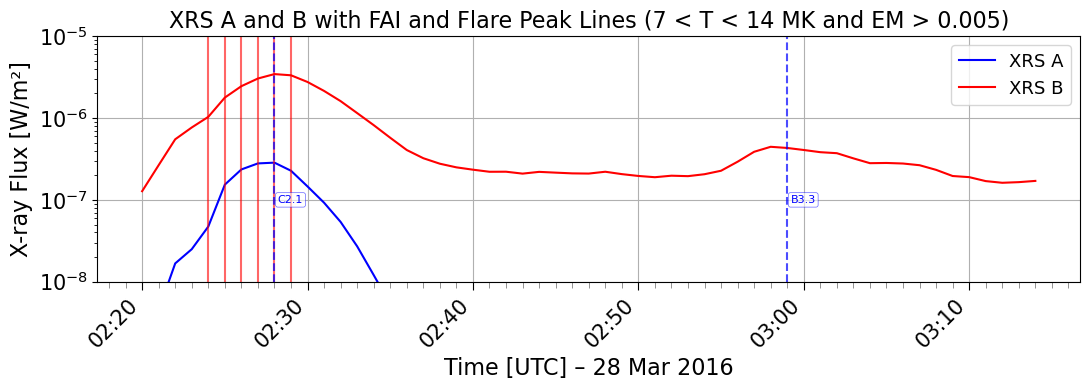

In [36]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2016-03-28 02:20:00",
    flare_end_time="2016-03-28 03:14:00", 
    ymin=1e-8, ymax=1e-5)

## Análisis correlaciones

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 08:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-09 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 01:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 05:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 12:21:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 21:03:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 03:45:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 12:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 02:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:14:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:39:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 09:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 10:36:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 13:40:00 no encontrado en da

/tmp/ipykernel_2084769/3513685990.py:838: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


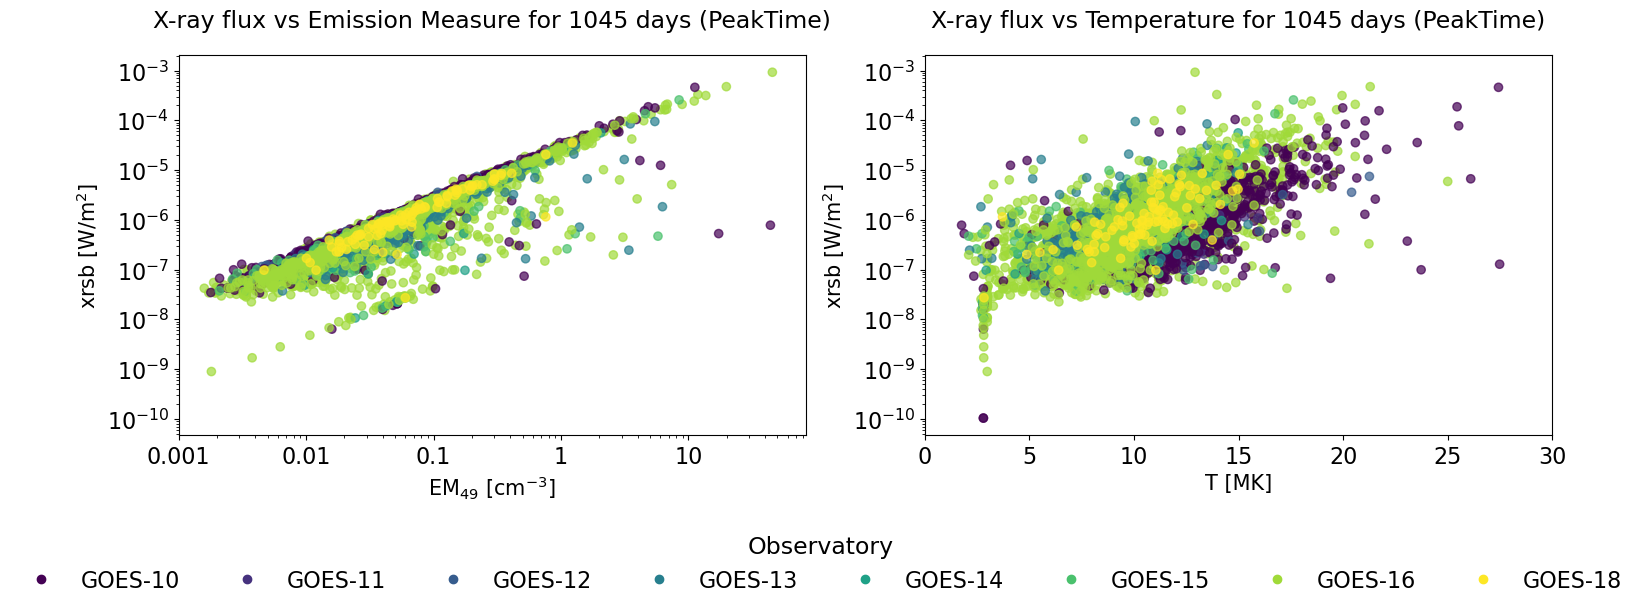

In [37]:
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Observatory",      # "None" o "Class" o "Date" u "Observatory" # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 08:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-09 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 01:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 05:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 12:21:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 21:03:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 03:45:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 12:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 02:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:14:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:39:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 09:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 10:36:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 13:40:00 no encontrado en da

/tmp/ipykernel_2084769/3513685990.py:838: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


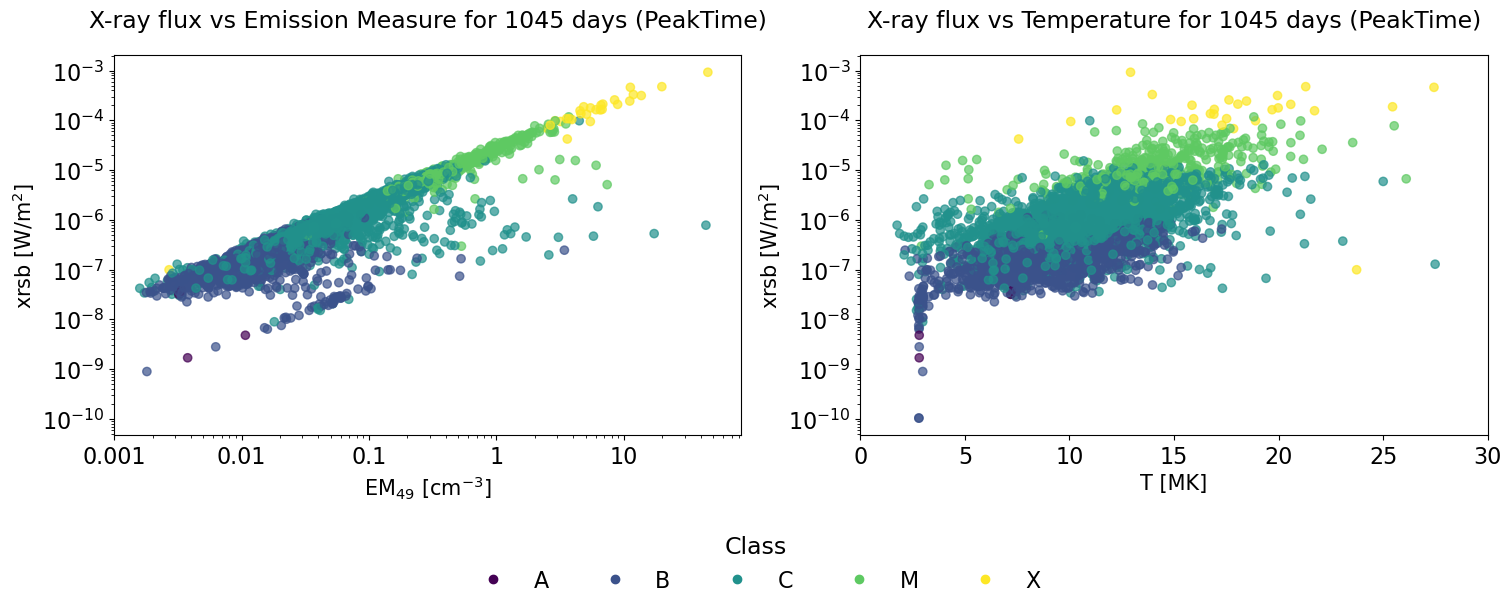

In [38]:
# grafica de características de flares en el peak
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 18:18:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 08:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-09 23:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 01:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 05:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 12:21:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 21:03:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 03:45:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-26 12:52:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 02:55:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:14:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:39:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 09:57:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 10:36:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 13:40:00 no encontrado en da

/tmp/ipykernel_2084769/3513685990.py:838: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


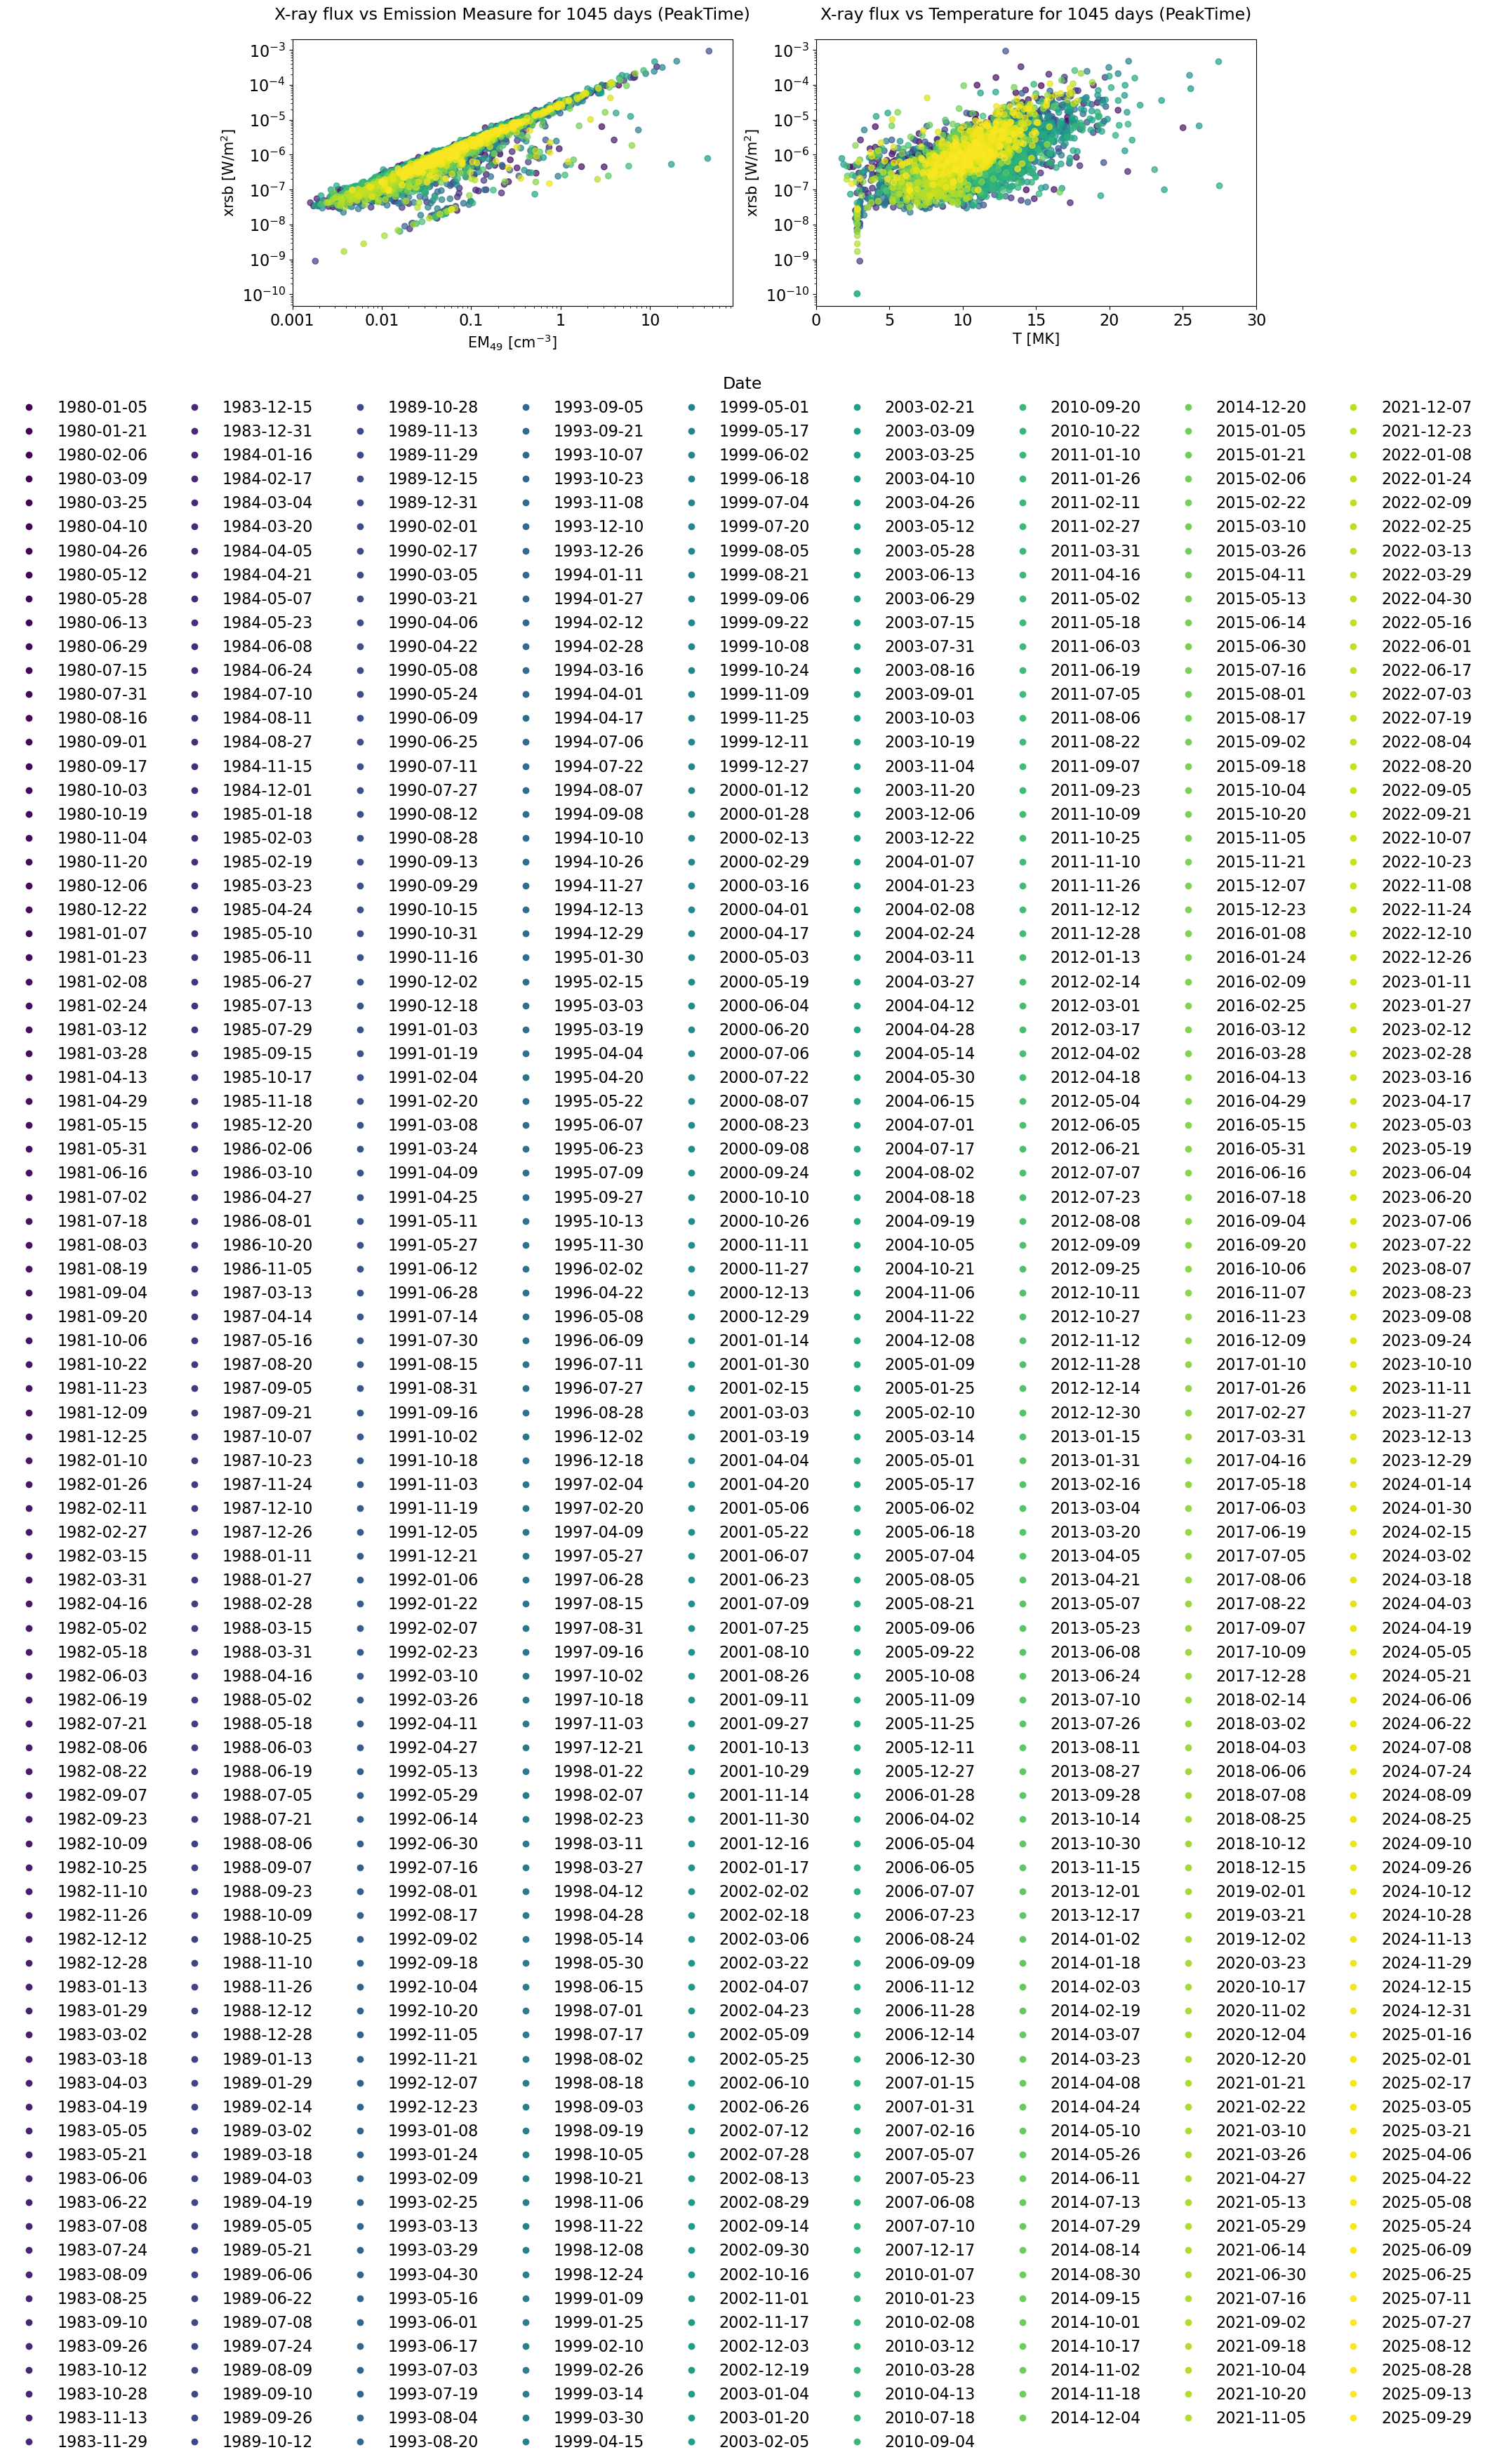

In [39]:

plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="PeakTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Date",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

Flare en 1980-01-05 15:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-05 17:46:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-05 18:56:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 05:20:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 08:51:00 no encontrado en datos GOES, se salta.
Flare en 1980-01-21 18:08:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 01:45:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 05:43:00 no encontrado en datos GOES, se salta.
Flare en 1980-03-25 21:03:00 no encontrado en datos GOES, se salta.
Flare en 1980-04-10 16:59:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 02:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:10:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 07:36:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 09:54:00 no encontrado en datos GOES, se salta.
Flare en 1980-05-12 10:13:00 no encontrado en da

/tmp/ipykernel_2084769/3513685990.py:838: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=bottom_space)


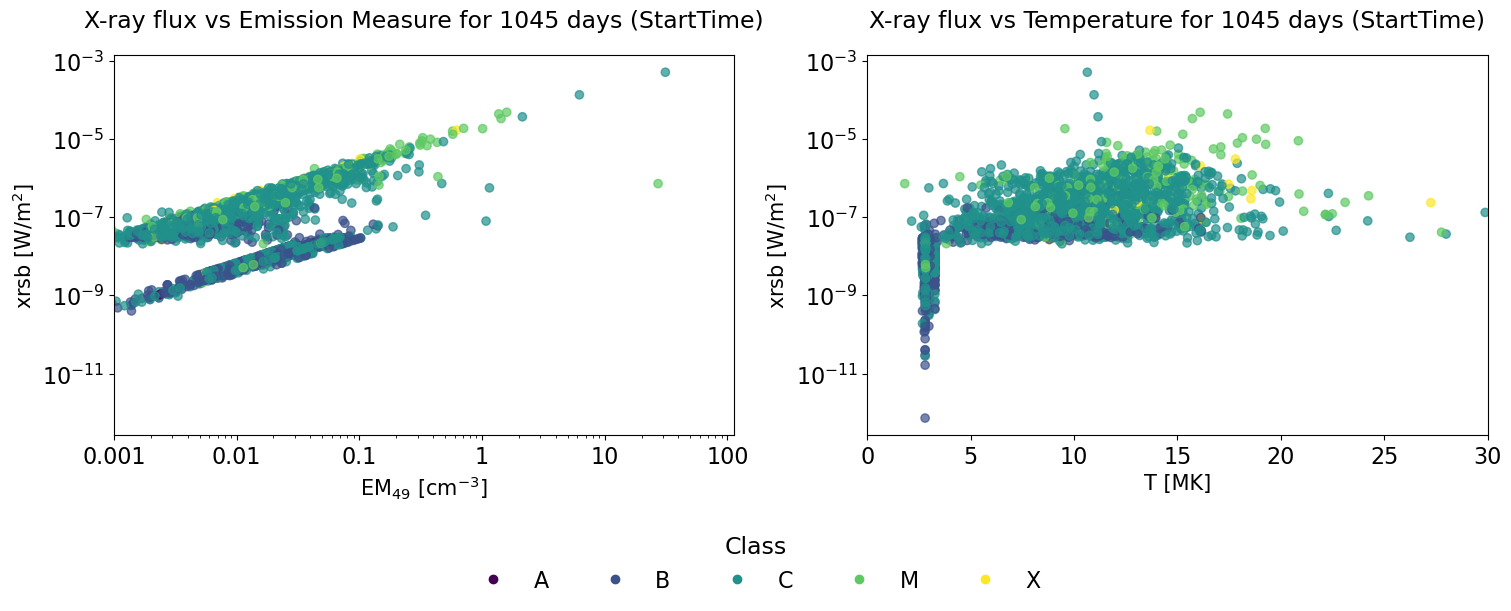

In [40]:
# grafica de características de flares en el peak
plot_xrs_vs_te_from_csv2(days=n, 
                            csv_full = filtered_file, 
                            csv_flares = csv_flares, 
                            time_column="StartTime",
                            XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                            color_by="Class",      # "None" o "Class" o "Date"  # opcional: colorea puntos azúl, según la clase de flare o la fecha
                            palette="viridis",  #  'Set2', 'tab20', 'viridis', 'plasma', 'coolwarm'
                            class_to_color=None # dict de colores fijos
                            )

## Analysis FAI

### Flare with FAI before

/tmp/ipykernel_2084769/3513685990.py:610: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


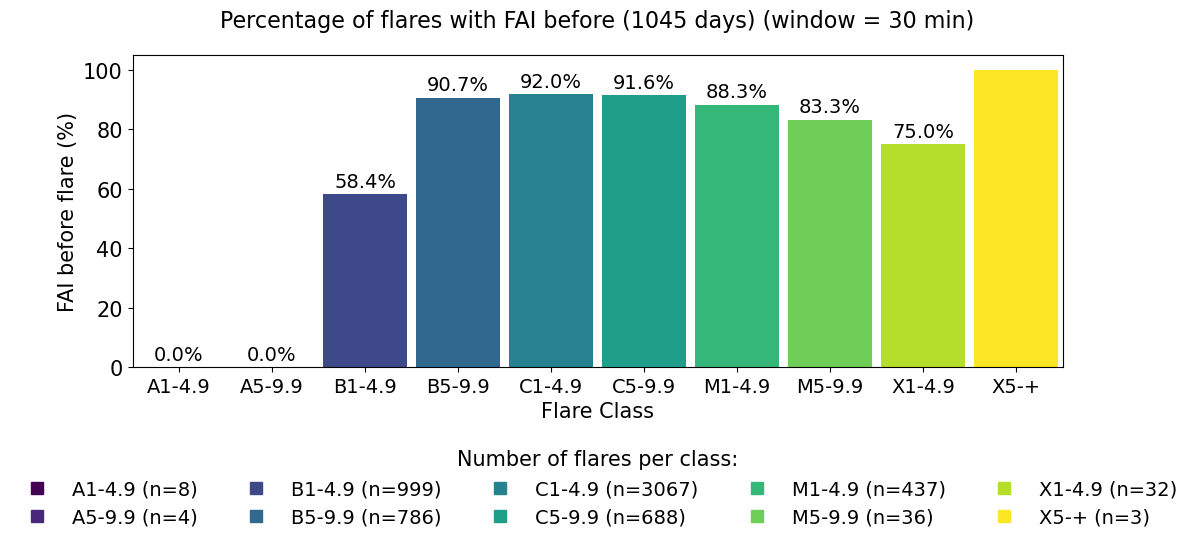

In [41]:
plot_flare_summary_from_csv2(csv_fai_before=csv_fai_before,
                                n_days=n,
                                window_minutes=window_minutes,
                                group_subclasses=True,
                                color_mode="palette:viridis")


/tmp/ipykernel_2084769/3513685990.py:610: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


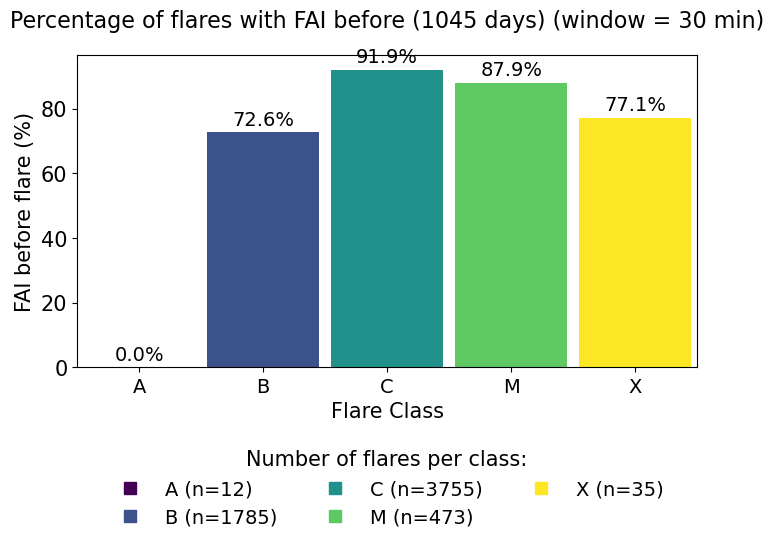

In [42]:
plot_flare_summary_from_csv2(csv_fai_before=csv_fai_before,
                                n_days=n,
                                window_minutes=window_minutes,
                                group_subclasses=False,
                                color_mode="palette:viridis")

### Total flares with FAIs

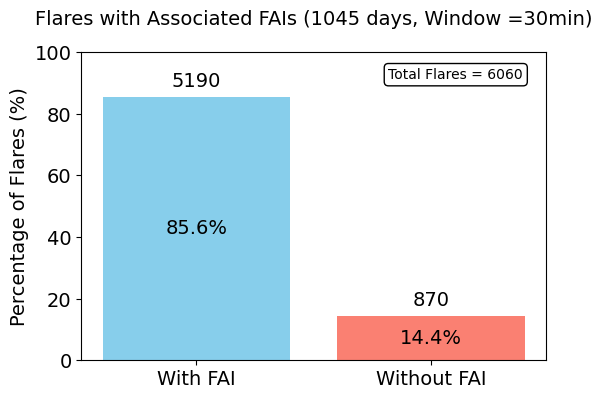

In [43]:
plot_fai_association(csv_fai_before=csv_fai_before, n=n, fai_column="FAI_before_flare")

### FAIs que están asociados a flares

In [44]:
df_fai_assoc = associate_fai_to_flare(csv_fai_selected=csv_fai_selected,
                                        csv_flares=csv_flares,
                                        window_minutes=window_minutes,
                                        time_ref='PeakTime'
                                    )
df_fai_assoc.to_csv(os.path.join(analysis_dir, "df_fai_assoc.csv"))

In [45]:
df_fai_assoc

Unnamed: 0 observatory          xrsa      xrsb     xrsa_corr  \
0      1980-01-05 00:13:00     GOES-16  2.171900e-08  0.000002  7.478500e-09   
1      1980-01-05 00:14:00     GOES-16  2.218579e-08  0.000002  7.978946e-09   
2      1980-01-05 00:15:00     GOES-16  2.081550e-08  0.000002  7.781501e-09   
3      1980-01-05 00:16:00     GOES-16  1.939105e-08  0.000002  6.772209e-09   
4      1980-01-05 00:45:00     GOES-16  2.091579e-08  0.000001  6.412631e-09   
...                    ...         ...           ...       ...           ...   
86699  2025-09-29 22:48:00     GOES-18  7.624613e-08  0.000003  3.078736e-08   
86700  2025-09-29 22:49:00     GOES-18  1.590250e-07  0.000004  1.156194e-07   
86701  2025-09-29 22:50:00     GOES-18  1.619349e-07  0.000004  1.142348e-07   
86702  2025-09-29 22:51:00     GOES-18  1.015141e-07  0.000003  4.584824e-08   
86703  2025-09-29 22:52:00     GOES-18  8.856041e-08  0.000003  2.283593e-08   

          xrsb_corr      T_cor        EM_cor    T_phot       EM_phot  \
0      1.702001e-07   7.404709  1.419828e+47  6.444598  4.887520e+47   
1      1.800003e-07   7.434225  1.489869e+47  6.471225  5.118306e+47   
2      1.818001e-07   7.317579  1.552705e+47  6.366079  5.376859e+47   
3      1.667369e-07   7.147209  1.493902e+47  6.212901  5.234078e+47   
4      9.663154e-08   8.966467  5.763681e+46  7.876660  1.788404e+47   
...             ...        ...           ...       ...           ...   
86699  3.466723e-07   9.438946  2.045536e+47  8.408052  5.995334e+47   
86700  9.266773e-07  11.054958  4.433774e+47  9.999961  1.179989e+48   
86701  1.189346e-06   9.788280  6.661454e+47  8.740891  1.913100e+48   
86702  7.408835e-07   8.024426  5.686657e+47  7.092611  1.814465e+48   
86703  4.496876e-07   7.373090  4.049882e+47  6.497513  1.346327e+48   

       EM_cor_norm  EM_phot_norm            Time_FAI  Associated_Flare  \
0         0.014198      0.048875 1980-01-05 00:13:00             False   
1         0.014899      0.051183 1980-01-05 00:14:00             False   
2         0.015527      0.053769 1980-01-05 00:15:00             False   
3         0.014939      0.052341 1980-01-05 00:16:00             False   
4         0.005764      0.017884 1980-01-05 00:45:00             False   
...            ...           ...                 ...               ...   
86699     0.020455      0.059953 2025-09-29 22:48:00              True   
86700     0.044338      0.117999 2025-09-29 22:49:00              True   
86701     0.066615      0.191310 2025-09-29 22:50:00              True   
86702     0.056867      0.181447 2025-09-29 22:51:00             False   
86703     0.040499      0.134633 2025-09-29 22:52:00             False   

          Flare_StartTime       Flare_EndTime      Flare_PeakTime Flare_Class  \
0                     NaT                 NaT                 NaT        None   
1                     NaT                 NaT                 NaT        None   
2                     NaT                 NaT                 NaT        None   
3                     NaT                 NaT                 NaT        None   
4                     NaT                 NaT                 NaT        None   
...                   ...                 ...                 ...         ...   
86699 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86700 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86701 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86702                 NaT                 NaT                 NaT        None   
86703                 NaT                 NaT                 NaT        None   

      Time_to_flare  
0              None  
1              None  
2              None  
3              None  
4              None  
...             ...  
86699           2.0  
86700           1.0  
86701           0.0  
86702          None  
86703          None  

[86704 rows x 19 columns]

In [46]:
# Filtrar solo las FAIs asociadas a un flare
df_fai_with_flare = df_fai_assoc[df_fai_assoc["Associated_Flare"] == True]

df_fai_with_flare

Unnamed: 0 observatory          xrsa      xrsb     xrsa_corr  \
103    1980-01-05 15:05:00     GOES-16  4.184450e-08  0.000002  2.885000e-08   
104    1980-01-05 15:06:00     GOES-16  3.854421e-08  0.000002  2.586137e-08   
105    1980-01-05 15:07:00     GOES-16  3.547100e-08  0.000002  2.464980e-08   
106    1980-01-05 15:08:00     GOES-16  3.407790e-08  0.000002  2.139474e-08   
107    1980-01-05 15:13:00     GOES-16  8.466263e-08  0.000002  5.058473e-08   
...                    ...         ...           ...       ...           ...   
86697  2025-09-29 22:46:00     GOES-18  5.566583e-08  0.000003  1.550804e-08   
86698  2025-09-29 22:47:00     GOES-18  6.572448e-08  0.000003  2.262554e-08   
86699  2025-09-29 22:48:00     GOES-18  7.624613e-08  0.000003  3.078736e-08   
86700  2025-09-29 22:49:00     GOES-18  1.590250e-07  0.000004  1.156194e-07   
86701  2025-09-29 22:50:00     GOES-18  1.619349e-07  0.000004  1.142348e-07   

          xrsb_corr      T_cor        EM_cor     T_phot       EM_phot  \
103    2.592000e-07  11.440485  1.119124e+47  10.344282  2.956234e+47   
104    3.012630e-07  10.135790  1.507479e+47   8.996251  4.341833e+47   
105    3.258000e-07   9.543546  1.771247e+47   8.421849  5.297078e+47   
106    2.974735e-07   9.315839  1.674916e+47   8.205315  5.081995e+47   
107    5.375263e-07  10.585282  2.544013e+47   9.446602  7.116229e+47   
...             ...        ...           ...        ...           ...   
86697  1.843457e-07   9.206715  1.128705e+47   8.188946  3.353612e+47   
86698  2.592360e-07   9.363621  1.547737e+47   8.336788  4.556436e+47   
86699  3.466723e-07   9.438946  2.045536e+47   8.408052  5.995334e+47   
86700  9.266773e-07  11.054958  4.433774e+47   9.999961  1.179989e+48   
86701  1.189346e-06   9.788280  6.661454e+47   8.740891  1.913100e+48   

       EM_cor_norm  EM_phot_norm            Time_FAI  Associated_Flare  \
103       0.011191      0.029562 1980-01-05 15:05:00              True   
104       0.015075      0.043418 1980-01-05 15:06:00              True   
105       0.017712      0.052971 1980-01-05 15:07:00              True   
106       0.016749      0.050820 1980-01-05 15:08:00              True   
107       0.025440      0.071162 1980-01-05 15:13:00              True   
...            ...           ...                 ...               ...   
86697     0.011287      0.033536 2025-09-29 22:46:00              True   
86698     0.015477      0.045564 2025-09-29 22:47:00              True   
86699     0.020455      0.059953 2025-09-29 22:48:00              True   
86700     0.044338      0.117999 2025-09-29 22:49:00              True   
86701     0.066615      0.191310 2025-09-29 22:50:00              True   

          Flare_StartTime       Flare_EndTime      Flare_PeakTime Flare_Class  \
103   1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
104   1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
105   1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
106   1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
107   1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
...                   ...                 ...                 ...         ...   
86697 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86698 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86699 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86700 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   
86701 2025-09-29 22:44:00 2025-09-29 22:53:00 2025-09-29 22:50:00        C3.8   

      Time_to_flare  
103            27.0  
104            26.0  
105            25.0  
106            24.0  
107            19.0  
...             ...  
86697           4.0  
86698           3.0  
86699           2.0  
86700           1.0  
86701           0.0  

[36979 rows x 19 columns]

In [47]:
df_fai_assoc.to_csv(os.path.join(analysis_dir, "df_fai_assoc.csv"))

In [48]:
df_fai_with_flare.iloc[:5]

Unnamed: 0 observatory          xrsa      xrsb     xrsa_corr  \
103  1980-01-05 15:05:00     GOES-16  4.184450e-08  0.000002  2.885000e-08   
104  1980-01-05 15:06:00     GOES-16  3.854421e-08  0.000002  2.586137e-08   
105  1980-01-05 15:07:00     GOES-16  3.547100e-08  0.000002  2.464980e-08   
106  1980-01-05 15:08:00     GOES-16  3.407790e-08  0.000002  2.139474e-08   
107  1980-01-05 15:13:00     GOES-16  8.466263e-08  0.000002  5.058473e-08   

        xrsb_corr      T_cor        EM_cor     T_phot       EM_phot  \
103  2.592000e-07  11.440485  1.119124e+47  10.344282  2.956234e+47   
104  3.012630e-07  10.135790  1.507479e+47   8.996251  4.341833e+47   
105  3.258000e-07   9.543546  1.771247e+47   8.421849  5.297078e+47   
106  2.974735e-07   9.315839  1.674916e+47   8.205315  5.081995e+47   
107  5.375263e-07  10.585282  2.544013e+47   9.446602  7.116229e+47   

     EM_cor_norm  EM_phot_norm            Time_FAI  Associated_Flare  \
103     0.011191      0.029562 1980-01-05 15:05:00              True   
104     0.015075      0.043418 1980-01-05 15:06:00              True   
105     0.017712      0.052971 1980-01-05 15:07:00              True   
106     0.016749      0.050820 1980-01-05 15:08:00              True   
107     0.025440      0.071162 1980-01-05 15:13:00              True   

        Flare_StartTime       Flare_EndTime      Flare_PeakTime Flare_Class  \
103 1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
104 1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
105 1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
106 1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   
107 1980-01-05 15:10:00 1980-01-05 15:47:00 1980-01-05 15:32:00        C9.0   

    Time_to_flare  
103          27.0  
104          26.0  
105          25.0  
106          24.0  
107          19.0

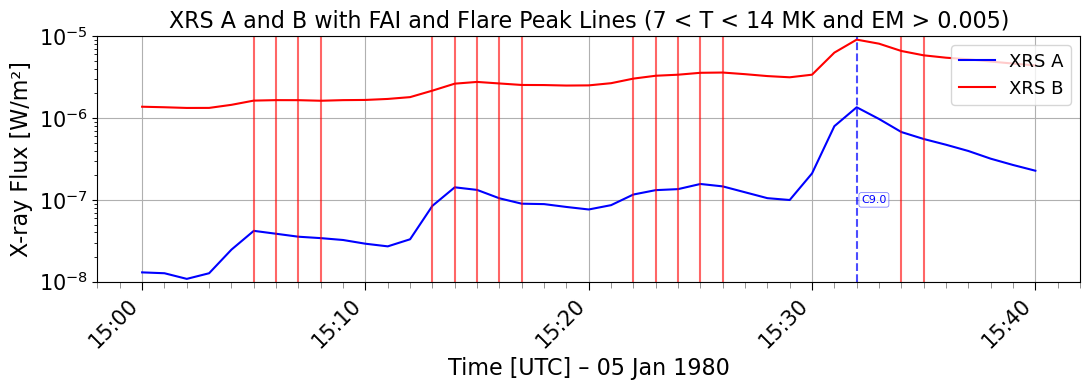

In [49]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="1980-01-05 15:00:00",
    flare_end_time="1980-01-05 15:40:00", 
    ymin=1e-8, ymax=1e-5)

### Graphs FAIs

In [50]:
# archivo df_fai_assoc fai con flare asociado
# ,Unnamed: 0,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,
# Time_FAI,Associated_Flare,Flare_StartTime,Flare_EndTime,Flare_PeakTime,Flare_Class,Time_to_flare
csv_fai_assoc= os.path.join(analysis_dir, "df_fai_assoc.csv")

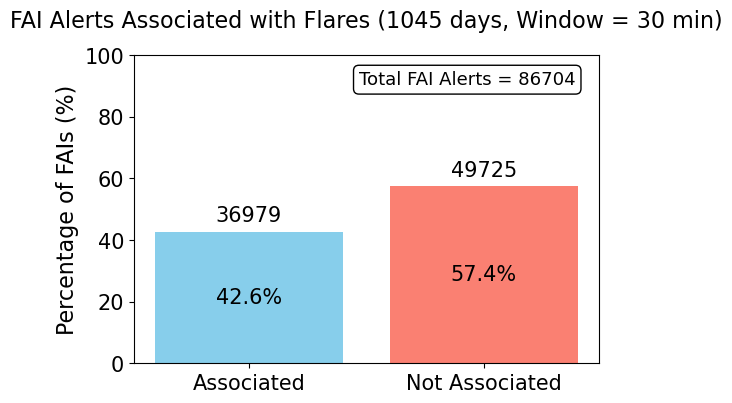

In [51]:
plot_fai_association_summary(csv_fai_assoc=csv_fai_assoc, window = window_minutes, column="Associated_Flare")

/tmp/ipykernel_2084769/3513685990.py:1169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


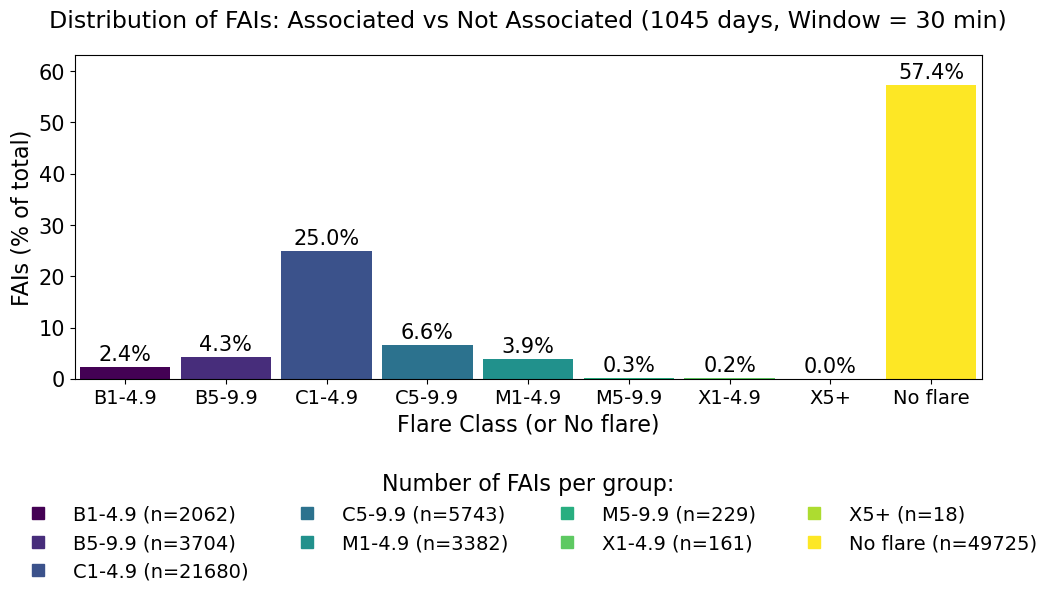

In [52]:
# Usar rangos C1–4.9, C5–9.9, X5+ y paleta viridis
plot_fai_distribution(csv_fai_assoc, window = window_minutes, group_subclasses=True, color_mode="palette:viridis")

/tmp/ipykernel_2084769/3513685990.py:1169: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


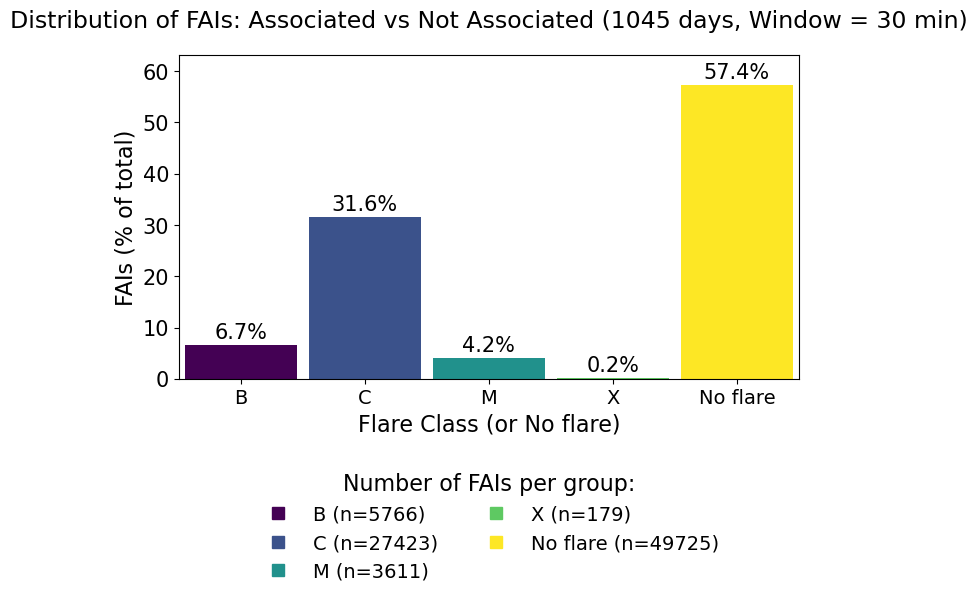

In [53]:
# Usar clases, X5+ y paleta viridis
plot_fai_distribution(csv_fai_assoc, window = window_minutes, group_subclasses=False, color_mode="palette:viridis")

### Por clases


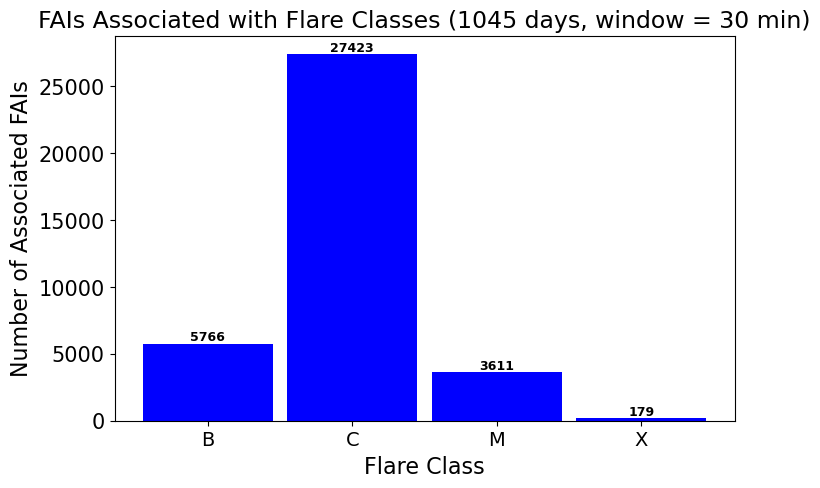

In [54]:
# Por letra
# Color único
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="letter", color_mode="single:blue")


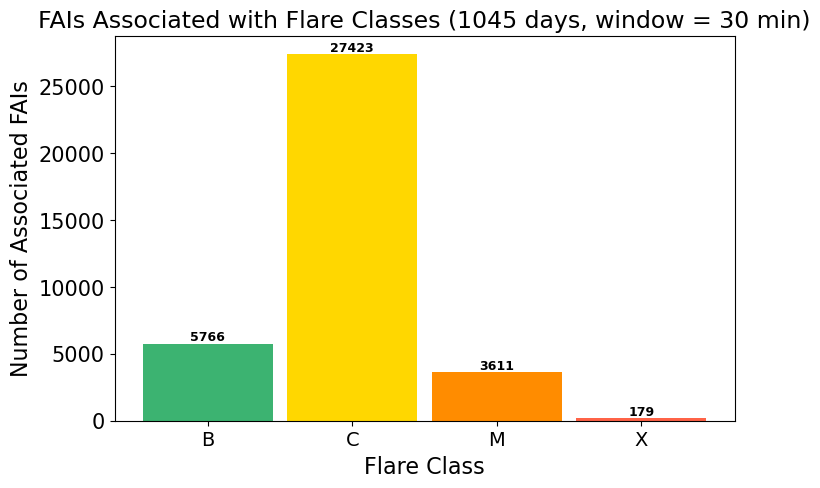

In [55]:
# Colores por clase
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="letter", color_mode="by_class")

/tmp/ipykernel_2084769/3513685990.py:1329: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


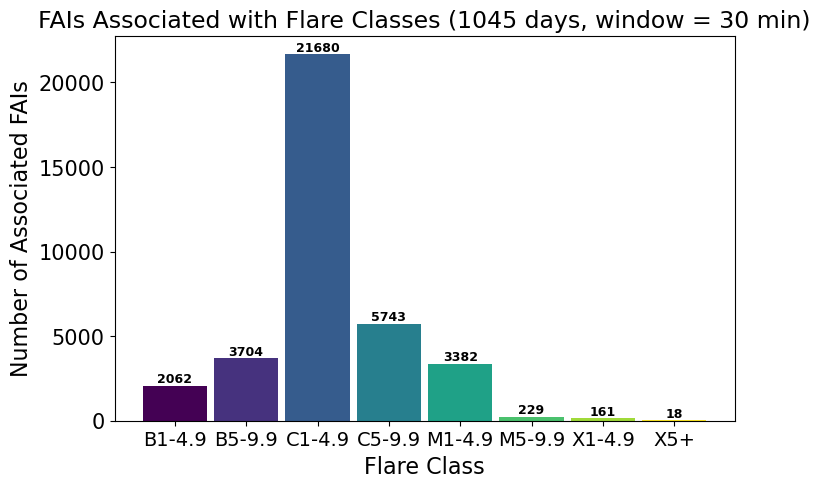

In [56]:
# Por rangos (usa los group_ranges definidos dentro de la función)
# Paleta viridis
plot_fai_by_flare_class(csv_fai_assoc, window=window_minutes, group_mode="range", color_mode="palette:viridis")

### otros

In [57]:
# Ordenar solo para visualizar 
df_sorted_anticipation_time = anticipation_time.sort_values(by="Anticipation (min)", ascending=False)

df_sorted_anticipation_time.iloc[:10]

Unnamed: 0           StartTime             EndTime Class Observatory  \
738            6 1983-05-21 19:47:00 1983-05-21 20:02:00  C1.2        GOES   
4897           1 2016-03-28 02:54:00 2016-03-28 03:04:00  B3.3        GOES   
4319           4 2011-09-23 08:40:00 2011-09-23 09:20:00  C6.9        GOES   
1493           0 1989-12-31 00:57:00 1989-12-31 01:10:00  C4.1        GOES   
5120           7 2021-01-21 10:27:00 2021-01-21 10:36:00  B3.3        GOES   
5082           1 2019-02-01 08:37:00 2019-02-01 09:44:00  B1.8        GOES   
1591           0 1990-09-29 04:06:00 1990-09-29 04:20:00  C9.4        GOES   
5699           4 2024-03-18 04:41:00 2024-03-18 04:51:00  C4.9        GOES   
3446          11 2002-08-29 19:25:00 2002-08-29 19:32:00  C5.2        GOES   
1764          10 1991-06-12 18:25:00 1991-06-12 18:40:00  C5.5        GOES   

                PeakTime  Anticipation (min)        Previous FAI  \
738  1983-05-21 19:47:00                30.0 1983-05-21 19:17:00   
4897 2016-03-28 02:59:00                30.0 2016-03-28 02:29:00   
4319 2011-09-23 08:50:00                30.0 2011-09-23 08:20:00   
1493 1989-12-31 00:57:00                30.0 1989-12-31 00:27:00   
5120 2021-01-21 10:30:00                30.0 2021-01-21 10:00:00   
5082 2019-02-01 09:13:00                30.0 2019-02-01 08:43:00   
1591 1990-09-29 04:08:00                30.0 1990-09-29 03:38:00   
5699 2024-03-18 04:45:00                30.0 2024-03-18 04:15:00   
3446 2002-08-29 19:28:00                30.0 2002-08-29 18:58:00   
1764 1991-06-12 18:30:00                30.0 1991-06-12 18:00:00   

      Time_since_prev_flare (min) observatory          xrsa          xrsb  \
738                           NaN     GOES-16  1.781895e-08  1.020421e-06   
4897                         31.0     GOES-13  2.271784e-07  3.339445e-06   
4319                         31.0     GOES-15  2.305791e-07  3.951543e-06   
1493                          NaN     GOES-16  1.041500e-07  3.569000e-06   
5120                         31.0     GOES-16  3.606715e-08  5.220152e-07   
5082                          NaN     GOES-16  1.070901e-08  1.428463e-07   
1591                          NaN     GOES-16  1.335882e-08  6.488235e-07   
5699                         31.0     GOES-16  1.383220e-06  1.082960e-05   
3446                          NaN     GOES-10  1.032849e-07  3.055861e-06   
1764                         31.0     GOES-16  1.387500e-06  1.235000e-05   

         xrsa_corr     xrsb_corr      T_cor        EM_cor     T_phot  \
738   5.182105e-09  1.483580e-07   7.097108  1.640192e+47   6.167963   
4897  1.799797e-07  2.303377e-06   9.338353  1.473780e+48   8.278693   
4319  1.452801e-07  1.634949e-06  10.192224  8.460604e+47   9.049279   
1493  1.373235e-08  2.595884e-07   8.657016  2.089264e+47   7.586927   
5120  2.260030e-08  3.821780e-07   7.851227  3.035091e+47   6.926807   
5082  3.213327e-09  6.195704e-08   7.422185  5.475159e+46   6.535639   
1591  6.452823e-09  1.148235e-07   8.900321  8.846236e+46   7.813234   
5699  7.728243e-07  5.397932e-06  11.762177  2.399225e+48  10.736679   
3446  1.223633e-08  2.392267e-07   9.004851  1.566206e+47   7.948771   
1764  5.871500e-07  5.705499e-06  11.730161  3.071904e+48  10.661670   

           EM_phot  EM_cor_norm  EM_phot_norm  
738   5.766408e+47     0.016402      0.057664  
4897  4.395172e+48     0.147378      0.439517  
4319  2.437389e+48     0.084606      0.243739  
1493  6.619630e+47     0.020893      0.066196  
5120  9.814699e+47     0.030351      0.098147  
5082  1.819188e+47     0.005475      0.018192  
1591  2.758960e+47     0.008846      0.027590  
5699  6.119111e+48     0.239923      0.611911  
3446  4.797007e+47     0.015662      0.047970  
1764  7.962694e+48     0.307190      0.796269

In [58]:
print(anticipation_time["Anticipation (min)"].min(), anticipation_time["Anticipation (min)"].max())

1.0 30.0


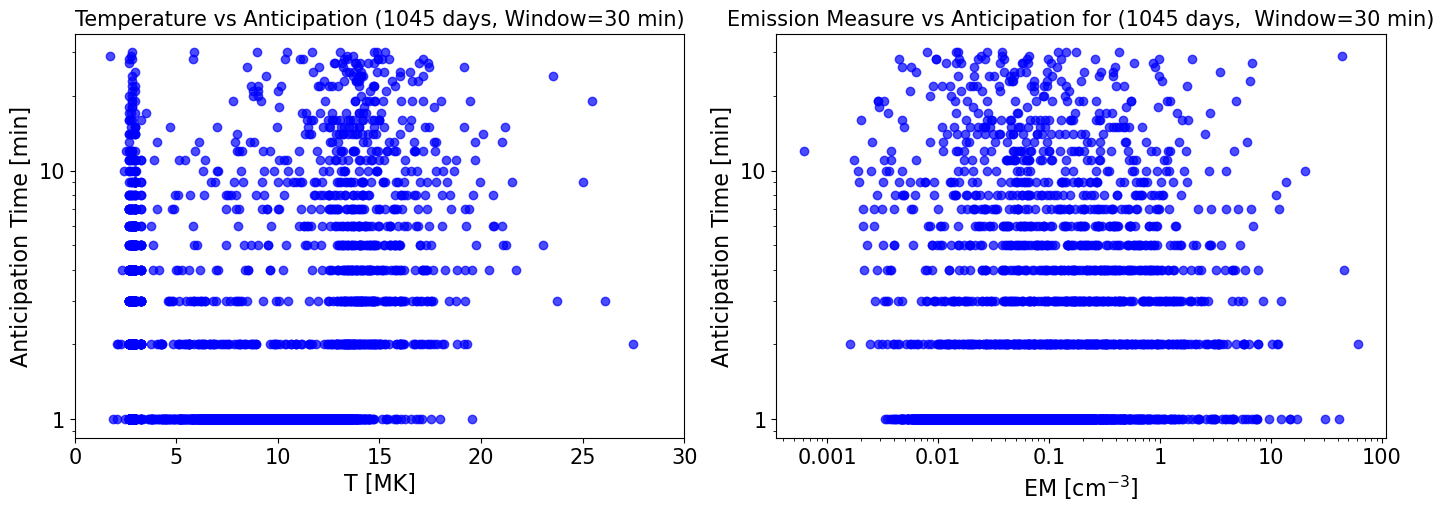

In [59]:
plot_anticipation_vs_te(days=n,
                            max_gap_fai = window_minutes,
                            csv_full=csv_full,
                            csv_flares=csv_flares,
                            csv_anticipation=csv_anticipation_time,
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor_norm",
                            color_by=None,        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None   # dict de colores fijos
                            )

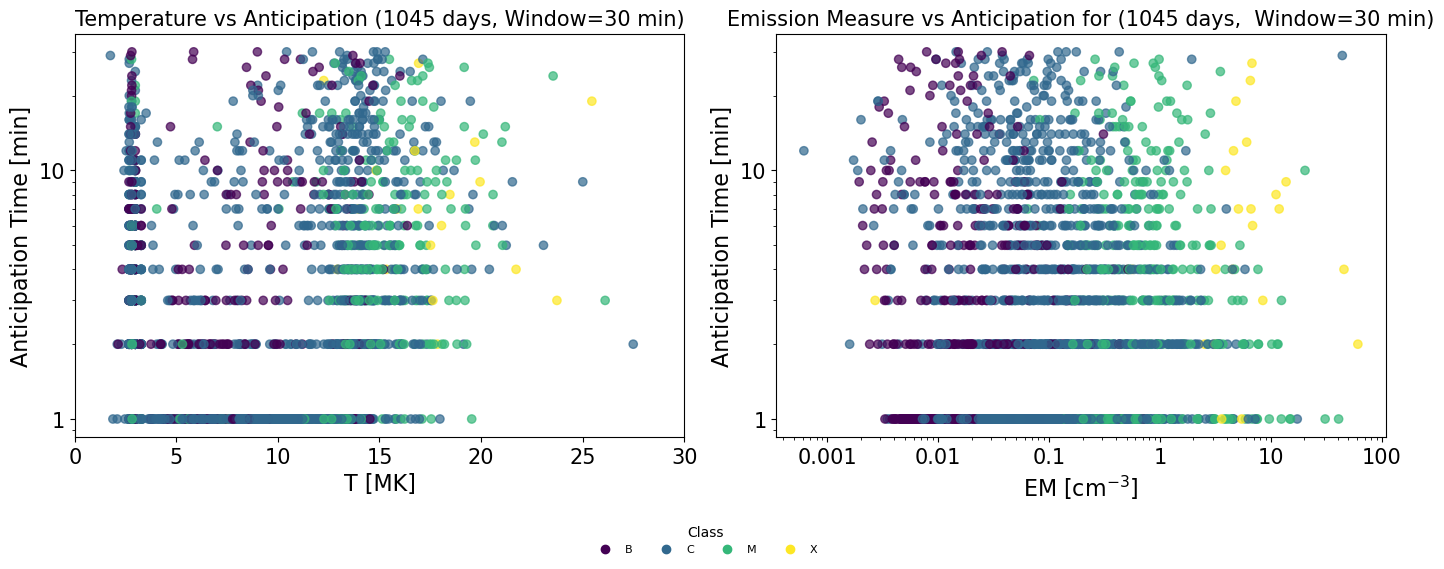

In [60]:
plot_anticipation_vs_te(days=n,
                            max_gap_fai = window_minutes,
                            csv_full=csv_full,
                            csv_flares=csv_flares,
                            csv_anticipation=csv_anticipation_time,
                            time_column="PeakTime",
                            T="T_cor", EM="EM_cor_norm",
                            color_by="Class",        # "Class" o "Date" u "Observatory"
                            palette="viridis",
                            class_to_color=None   # dict de colores fijos
                            )

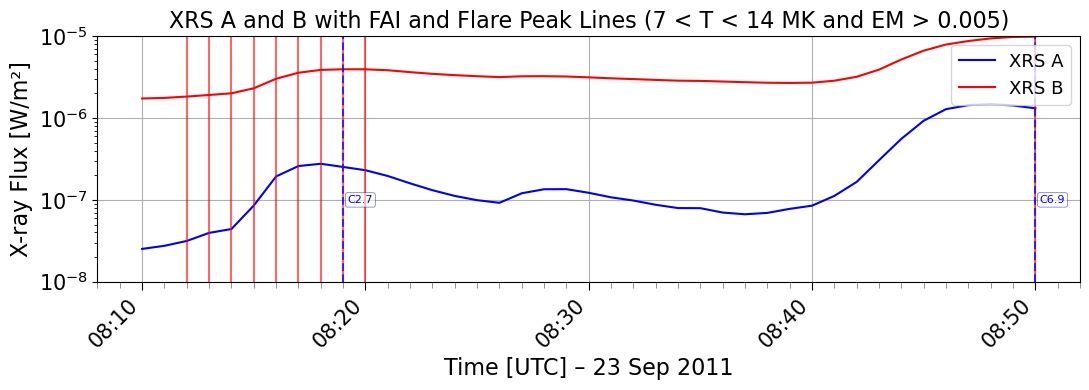

In [61]:

plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2011-09-23 08:10:00",
    flare_end_time="2011-09-23 08:50:00", 
    ymin=1e-8, ymax=1e-5)


In [62]:
# Filtrar primero y luego ordenar
df_sorted_anticipation_time_by_class = (
    anticipation_time[anticipation_time["Anticipation (min)"] > 5]  # filtro
    .sort_values(by="Class", ascending=False)                       # ordenar
)

# Mostrar un rango de filas
df_sorted_anticipation_time_by_class.iloc[:10]

Unnamed: 0           StartTime             EndTime Class Observatory  \
522            8 1982-06-03 11:41:00 1982-06-03 13:26:00  X8.0        GOES   
625            2 1982-11-26 02:30:00 1982-11-26 03:20:00  X4.5        GOES   
2837           1 1998-11-22 06:30:00 1998-11-22 06:49:00  X3.7        GOES   
2801           3 1998-08-18 08:14:00 1998-08-18 08:32:00  X2.8        GOES   
192            4 1981-02-24 12:02:00 1981-02-24 13:04:00  X2.3        GOES   
1330           2 1989-01-13 08:29:00 1989-01-13 10:45:00  X2.3        GOES   
1694           9 1991-03-08 20:20:00 1991-03-08 20:33:00  X1.7        GOES   
902           16 1984-04-21 20:09:00 1984-04-21 20:34:00  X1.7        GOES   
1063           4 1986-02-06 06:18:00 1986-02-06 07:53:00  X1.7        GOES   
4050          15 2006-12-14 21:07:00 2006-12-14 22:26:00  X1.5        GOES   

                PeakTime  Anticipation (min)        Previous FAI  \
522  1982-06-03 11:48:00                 7.0 1982-06-03 11:41:00   
625  1982-11-26 02:37:00                 7.0 1982-11-26 02:30:00   
2837 1998-11-22 06:42:00                 9.0 1998-11-22 06:33:00   
2801 1998-08-18 08:24:00                 8.0 1998-08-18 08:16:00   
192  1981-02-24 12:26:00                23.0 1981-02-24 12:03:00   
1330 1989-01-13 10:18:00                13.0 1989-01-13 10:05:00   
1694 1991-03-08 20:29:00                 6.0 1991-03-08 20:23:00   
902  1984-04-21 20:17:00                 7.0 1984-04-21 20:10:00   
1063 1986-02-06 06:25:00                27.0 1986-02-06 05:58:00   
4050 2006-12-14 22:15:00                10.0 2006-12-14 22:05:00   

      Time_since_prev_flare (min) observatory          xrsa          xrsb  \
522                          22.0     GOES-16  3.850800e-07  3.650350e-06   
625                           NaN     GOES-16  3.086250e-06  2.097750e-05   
2837                          NaN     GOES-16  1.189908e-07  1.753609e-06   
2801                          NaN     GOES-16  2.492737e-08  1.158576e-06   
192                           NaN     GOES-16  4.456421e-07  7.134526e-06   
1330                          NaN     GOES-16  2.149412e-06  1.711765e-05   
1694                          7.0     GOES-16  1.114937e-07  3.748750e-06   
902                          27.0     GOES-16  2.362550e-07  4.006500e-06   
1063                         52.0     GOES-16  2.405250e-08  5.415000e-07   
4050                          NaN     GOES-10  4.727059e-07  4.371428e-06   

         xrsa_corr     xrsb_corr      T_cor        EM_cor     T_phot  \
522   3.413865e-07  2.068750e-06  13.600497  7.567804e+47  12.826439   
625   2.842639e-06  1.702097e-05  13.671163  6.200372e+48  12.910676   
2837  9.194690e-08  7.509680e-07  12.651927  4.371681e+47  11.723086   
2801  1.184533e-08  1.365945e-07  10.935808  9.221667e+46   9.825241   
192   2.698474e-07  1.541632e-06  13.952708  5.525686e+47  13.247599   
1330  1.694118e-07  1.197646e-06  13.434436  5.682171e+47  12.630092   
1694  4.029375e-08  4.603289e-07  10.915558  2.686111e+47   9.785852   
902   1.342795e-07  9.344999e-07  13.581122  4.162069e+47  12.803364   
1063  2.080513e-08  2.036052e-07  11.693916  1.099814e+47  10.621550   
4050  2.915294e-07  2.285714e-06  13.639464  9.137069e+47  12.931677   

           EM_phot  EM_cor_norm  EM_phot_norm  
522   1.731254e+48     0.075678      0.173125  
625   1.412422e+49     0.620037      1.412422  
2837  1.066714e+48     0.043717      0.106671  
2801  2.523840e+47     0.009222      0.025238  
192   1.238004e+48     0.055257      0.123800  
1330  1.314603e+48     0.056822      0.131460  
1694  7.359380e+47     0.026861      0.073594  
902   9.532539e+47     0.041621      0.095325  
1063  2.858019e+47     0.010998      0.028580  
4050  2.067325e+48     0.091371      0.206732

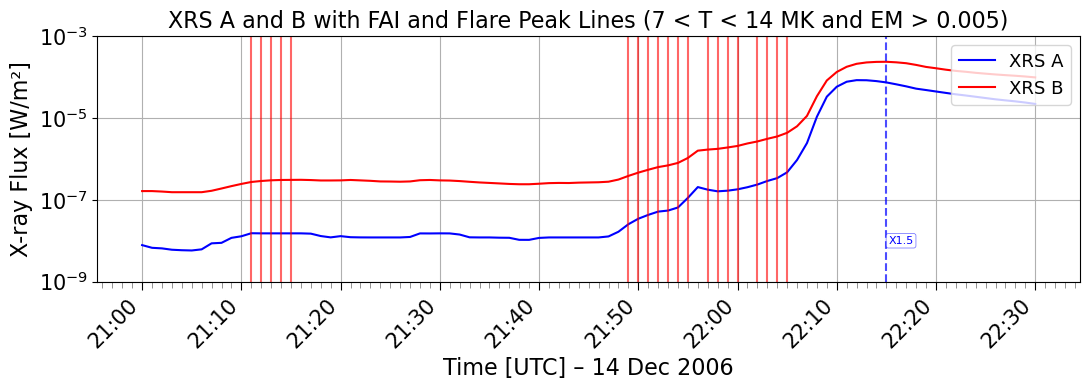

In [64]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flare_data,
    flare_start_time="2006-12-14 21:00:00",
    flare_end_time="2006-12-14 22:30:00", 
    ymin=1e-9, ymax=1e-3)